# Chicago Crime, Part 1
*  **Darlene Adams**

### Imports and Load

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import glob
import matplotlib.ticker as mticks
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

import holidays
import datetime as dt
from holidays import country_holidays
plt.rcParams['figure.facecolor']='white'
plt.rcParams['figure.figsize']=(12,4)
pd.set_option('display.max_columns',100)

sns.set_context("talk", font_scale=0.9)

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.ticker as mticks
import pmdarima as pm

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn import set_config

from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs, nsdiffs

import statsmodels.tsa.api as tsa
import itertools

plt.rcParams['figure.figsize']=(12,3)

import warnings
warnings.filterwarnings("ignore")

In [3]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None,
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)

    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index,
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();

    return fig, ax

In [4]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d,
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags,
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [5]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5),
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},
                  annotate_seas=False, m = None,
                 seas_color='black', method = 'ywm'):

    fig, axes = plt.subplots(nrows=2, figsize=figsize)
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')
    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )
    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    # Annotate sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)
    # seasons
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        # Calculate number of complete seasons to annotate
        n_seasons = nlags//m

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)

        # for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()

    return fig

In [6]:
def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [7]:
def millions(x,pos):
    """function for use wth matplotlib FuncFormatter -  formats money in millions"""
    new_x = x/1_000_000
    return f"{new_x:,.0f}M"
def thousands(x,pos):
    """function for use wth matplotlib FuncFormatter -  formats money in millions"""
    new_x = x/1_000
    return f"{new_x:,.0f}K"
# Create the formatters
fmt_mill = mticks.FuncFormatter(millions)
fmt_thous = mticks.FuncFormatter(thousands)
fmt_mill = mticks.FuncFormatter(millions)
fmt_thous = mticks.FuncFormatter(thousands)

In [8]:
crime_files = sorted(glob.glob("Data/Chicago-Crime_*.csv"))
crime_files


['Data\\Chicago-Crime_2001.csv',
 'Data\\Chicago-Crime_2002.csv',
 'Data\\Chicago-Crime_2003.csv',
 'Data\\Chicago-Crime_2004.csv',
 'Data\\Chicago-Crime_2005.csv',
 'Data\\Chicago-Crime_2006.csv',
 'Data\\Chicago-Crime_2007.csv',
 'Data\\Chicago-Crime_2008.csv',
 'Data\\Chicago-Crime_2009.csv',
 'Data\\Chicago-Crime_2010.csv',
 'Data\\Chicago-Crime_2011.csv',
 'Data\\Chicago-Crime_2012.csv',
 'Data\\Chicago-Crime_2013.csv',
 'Data\\Chicago-Crime_2014.csv',
 'Data\\Chicago-Crime_2015.csv',
 'Data\\Chicago-Crime_2016.csv',
 'Data\\Chicago-Crime_2017.csv',
 'Data\\Chicago-Crime_2018.csv',
 'Data\\Chicago-Crime_2019.csv',
 'Data\\Chicago-Crime_2020.csv',
 'Data\\Chicago-Crime_2021.csv',
 'Data\\Chicago-Crime_2022.csv']

In [9]:
# Use read_csv in a list comprehension and combine with concat to load all files
df = pd.concat([pd.read_csv(f) for f in crime_files] )
df.head()

ID                    Date     Primary Type          Description  \
0  1326041  01/01/2001 01:00:00 AM          BATTERY               SIMPLE   
1  1319931  01/01/2001 01:00:00 PM          BATTERY               SIMPLE   
2  1324743  01/01/2001 01:00:00 PM         GAMBLING  ILLEGAL ILL LOTTERY   
3  1310717  01/01/2001 01:00:00 AM  CRIMINAL DAMAGE           TO VEHICLE   
4  1318099  01/01/2001 01:00:00 AM          BATTERY               SIMPLE   

      Location Description  Arrest  Domestic  Beat  District  Ward   Latitude  \
0                RESIDENCE   False     False  1624      16.0   NaN  41.957850   
1                RESIDENCE   False      True   825       8.0   NaN  41.783892   
2                   STREET    True     False   313       3.0   NaN  41.780412   
3                   STREET   False     False  2424      24.0   NaN  42.012391   
4  RESIDENCE PORCH/HALLWAY   False      True   214       2.0   NaN  41.819538   

   Longitude  
0 -87.749185  
1 -87.684841  
2 -87.611970  
3 -87.678032  
4 -87.620020

In [10]:
df.columns

Index(['ID', 'Date', 'Primary Type', 'Description', 'Location Description',
       'Arrest', 'Domestic', 'Beat', 'District', 'Ward', 'Latitude',
       'Longitude'],
      dtype='object')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7713109 entries, 0 to 238857
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   ID                    int64  
 1   Date                  object 
 2   Primary Type          object 
 3   Description           object 
 4   Location Description  object 
 5   Arrest                bool   
 6   Domestic              bool   
 7   Beat                  int64  
 8   District              float64
 9   Ward                  float64
 10  Latitude              float64
 11  Longitude             float64
dtypes: bool(2), float64(4), int64(2), object(4)
memory usage: 662.0+ MB


In [12]:
# check for null values
df.isna().sum()

ID                           0
Date                         0
Primary Type                 0
Description                  0
Location Description     10928
Arrest                       0
Domestic                     0
Beat                         0
District                    47
Ward                    614846
Latitude                 88685
Longitude                88685
dtype: int64

In [13]:
ts = df
ts['Date'] = pd.to_datetime(ts['Date'], format='%m/%d/%Y %H:%M:%S %p')
ts = df.set_index('Date')
ts.head()

ID     Primary Type          Description  \
Date                                                                 
2001-01-01 01:00:00  1326041          BATTERY               SIMPLE   
2001-01-01 01:00:00  1319931          BATTERY               SIMPLE   
2001-01-01 01:00:00  1324743         GAMBLING  ILLEGAL ILL LOTTERY   
2001-01-01 01:00:00  1310717  CRIMINAL DAMAGE           TO VEHICLE   
2001-01-01 01:00:00  1318099          BATTERY               SIMPLE   

                        Location Description  Arrest  Domestic  Beat  \
Date                                                                   
2001-01-01 01:00:00                RESIDENCE   False     False  1624   
2001-01-01 01:00:00                RESIDENCE   False      True   825   
2001-01-01 01:00:00                   STREET    True     False   313   
2001-01-01 01:00:00                   STREET   False     False  2424   
2001-01-01 01:00:00  RESIDENCE PORCH/HALLWAY   False      True   214   

                     District  Ward   Latitude  Longitude  
Date                                                       
2001-01-01 01:00:00      16.0   NaN  41.957850 -87.749185  
2001-01-01 01:00:00       8.0   NaN  41.783892 -87.684841  
2001-01-01 01:00:00       3.0   NaN  41.780412 -87.611970  
2001-01-01 01:00:00      24.0   NaN  42.012391 -87.678032  
2001-01-01 01:00:00       2.0   NaN  41.819538 -87.620020

In [14]:
ts['Primary Type'].value_counts()

THEFT                                1626992
BATTERY                              1410889
CRIMINAL DAMAGE                       878914
NARCOTICS                             746155
ASSAULT                               501103
OTHER OFFENSE                         479174
BURGLARY                              422246
MOTOR VEHICLE THEFT                   366586
DECEPTIVE PRACTICE                    340958
ROBBERY                               289677
CRIMINAL TRESPASS                     212869
WEAPONS VIOLATION                     103906
PROSTITUTION                           69750
OFFENSE INVOLVING CHILDREN             55280
PUBLIC PEACE VIOLATION                 52086
SEX OFFENSE                            30442
CRIM SEXUAL ASSAULT                    27584
INTERFERENCE WITH PUBLIC OFFICER       18206
LIQUOR LAW VIOLATION                   14846
GAMBLING                               14616
ARSON                                  13121
HOMICIDE                               12394
KIDNAPPING

In [15]:
holidays = country_holidays('US', subdiv='IL')
ts['Holiday'] = [holidays.get(day) for day in ts.index]

In [16]:
ts['Holiday'].value_counts()

New Year's Day                                     32725
Independence Day                                   22672
Labor Day                                          22164
Memorial Day                                       21125
Columbus Day                                       20920
Veterans Day                                       20418
Casimir Pulaski Day                                19128
Lincoln's Birthday                                 18165
Martin Luther King Jr. Day                         17916
Washington's Birthday                              17597
Thanksgiving                                       14798
Christmas Day                                      12418
Election Day                                        6342
Independence Day (Observed)                         5884
Veterans Day (Observed)                             5842
Lincoln's Birthday (Observed)                       5156
Christmas Day (Observed)                            4929
New Year's Day (Observed)      

In [17]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7713109 entries, 2001-01-01 01:00:00 to 2022-12-31 12:59:00
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   ID                    int64  
 1   Primary Type          object 
 2   Description           object 
 3   Location Description  object 
 4   Arrest                bool   
 5   Domestic              bool   
 6   Beat                  int64  
 7   District              float64
 8   Ward                  float64
 9   Latitude              float64
 10  Longitude             float64
 11  Holiday               object 
dtypes: bool(2), float64(4), int64(2), object(4)
memory usage: 662.0+ MB


## Stakeholder Questions

### Topic 1) Comparing Police Districts


Which district had the most crimes in 2022
  
Which had the least?

In [18]:
crime_22 = ts.loc['2022']
crime_22

ID        Primary Type  \
Date                                                
2022-01-01 01:00:00  12582293               THEFT   
2022-01-01 01:00:00  12607313  DECEPTIVE PRACTICE   
2022-01-01 01:00:00  12585671     CRIMINAL DAMAGE   
2022-01-01 01:00:00  12592889       OTHER OFFENSE   
2022-01-01 01:00:00  12584977               THEFT   
...                       ...                 ...   
2022-12-31 12:50:00  12938029             ASSAULT   
2022-12-31 12:50:00  12937822             ASSAULT   
2022-12-31 12:52:00  12937583             BATTERY   
2022-12-31 12:52:00  12938420             ASSAULT   
2022-12-31 12:59:00  12939906  DECEPTIVE PRACTICE   

                                                 Description  \
Date                                                           
2022-01-01 01:00:00                           $500 AND UNDER   
2022-01-01 01:00:00  FINANCIAL IDENTITY THEFT $300 AND UNDER   
2022-01-01 01:00:00                               TO VEHICLE   
2022-01-01 01:00:00                  HARASSMENT BY TELEPHONE   
2022-01-01 01:00:00                           $500 AND UNDER   
...                                                      ...   
2022-12-31 12:50:00                                   SIMPLE   
2022-12-31 12:50:00                     AGGRAVATED - HANDGUN   
2022-12-31 12:52:00                                   SIMPLE   
2022-12-31 12:52:00                                   SIMPLE   
2022-12-31 12:59:00  FINANCIAL IDENTITY THEFT $300 AND UNDER   

                                       Location Description  Arrest  Domestic  \
Date                                                                            
2022-01-01 01:00:00                              RESTAURANT   False     False   
2022-01-01 01:00:00                                    BANK   False     False   
2022-01-01 01:00:00  PARKING LOT / GARAGE (NON RESIDENTIAL)   False     False   
2022-01-01 01:00:00                               APARTMENT   False     False   
2022-01-01 01:00:00                         OTHER (SPECIFY)   False     False   
...                                                     ...     ...       ...   
2022-12-31 12:50:00                               APARTMENT   False     False   
2022-12-31 12:50:00                               APARTMENT   False      True   
2022-12-31 12:52:00                              BARBERSHOP   False     False   
2022-12-31 12:52:00            COMMERCIAL / BUSINESS OFFICE   False     False   
2022-12-31 12:59:00                               RESIDENCE   False     False   

                     Beat  District  Ward   Latitude  Longitude  \
Date                                                              
2022-01-01 01:00:00   121       1.0  42.0  41.881884 -87.640060   
2022-01-01 01:00:00   811       8.0  23.0  41.787923 -87.769446   
2022-01-01 01:00:00   531       5.0   9.0  41.687443 -87.604120   
2022-01-01 01:00:00   412       4.0   8.0  41.734353 -87.585147   
2022-01-01 01:00:00  1811      18.0   2.0  41.910818 -87.654560   
...                   ...       ...   ...        ...        ...   
2022-12-31 12:50:00  1014      10.0  24.0  41.855911 -87.719966   
2022-12-31 12:50:00   733       7.0   6.0  41.766546 -87.645669   
2022-12-31 12:52:00  1135      11.0  28.0  41.868829 -87.686098   
2022-12-31 12:52:00  1432      14.0  32.0  41.930693 -87.685657   
2022-12-31 12:59:00  1511      15.0  29.0        NaN        NaN   

                            Holiday  
Date                                 
2022-01-01 01:00:00  New Year's Day  
2022-01-01 01:00:00  New Year's Day  
2022-01-01 01:00:00  New Year's Day  
2022-01-01 01:00:00  New Year's Day  
2022-01-01 01:00:00  New Year's Day  
...                             ...  
2022-12-31 12:50:00            None  
2022-12-31 12:50:00            None  
2022-12-31 12:52:00            None  
2022-12-31 12:52:00            None  
2022-12-31 12:59:00            None  

[238858 rows x 12 columns]

In [19]:
district_22 = crime_22['District']
district_22

Date
2022-01-01 01:00:00     1.0
2022-01-01 01:00:00     8.0
2022-01-01 01:00:00     5.0
2022-01-01 01:00:00     4.0
2022-01-01 01:00:00    18.0
                       ... 
2022-12-31 12:50:00    10.0
2022-12-31 12:50:00     7.0
2022-12-31 12:52:00    11.0
2022-12-31 12:52:00    14.0
2022-12-31 12:59:00    15.0
Name: District, Length: 238858, dtype: float64

In [23]:
d_2022 = district_22.groupby('Primary Type').resample('Y').count()
d_2022

KeyError: 'Primary Type'

In [ ]:
unstacked = d_2022.unstack(level=1)
unstacked

In [ ]:
d_2022['District'].max()

In [ ]:
d_2022['District'].min()

### Topic 1) Comparing Police Districts
*  Which district had the most crimes in 2022?
    *  District 8 had the most crimes in 2022 with 14,805
* Which had the least?
    * District 31 had the least crimes in 2022 with 15

### Topic 4) Comparing Months:

* ​What months have the most crime?
* What months have the least?
* Are there any individual crimes that do not follow this pattern?
* If so, which crimes?

In [24]:
ts1 = ts.copy()
ts1['Month']  = ts1.index.month
ts1['Month Name'] = ts1.index.month_name()
ts1.head()

ID     Primary Type          Description  \
Date                                                                 
2001-01-01 01:00:00  1326041          BATTERY               SIMPLE   
2001-01-01 01:00:00  1319931          BATTERY               SIMPLE   
2001-01-01 01:00:00  1324743         GAMBLING  ILLEGAL ILL LOTTERY   
2001-01-01 01:00:00  1310717  CRIMINAL DAMAGE           TO VEHICLE   
2001-01-01 01:00:00  1318099          BATTERY               SIMPLE   

                        Location Description  Arrest  Domestic  Beat  \
Date                                                                   
2001-01-01 01:00:00                RESIDENCE   False     False  1624   
2001-01-01 01:00:00                RESIDENCE   False      True   825   
2001-01-01 01:00:00                   STREET    True     False   313   
2001-01-01 01:00:00                   STREET   False     False  2424   
2001-01-01 01:00:00  RESIDENCE PORCH/HALLWAY   False      True   214   

                     District  Ward   Latitude  Longitude         Holiday  \
Date                                                                        
2001-01-01 01:00:00      16.0   NaN  41.957850 -87.749185  New Year's Day   
2001-01-01 01:00:00       8.0   NaN  41.783892 -87.684841  New Year's Day   
2001-01-01 01:00:00       3.0   NaN  41.780412 -87.611970  New Year's Day   
2001-01-01 01:00:00      24.0   NaN  42.012391 -87.678032  New Year's Day   
2001-01-01 01:00:00       2.0   NaN  41.819538 -87.620020  New Year's Day   

                     Month Month Name  
Date                                   
2001-01-01 01:00:00      1    January  
2001-01-01 01:00:00      1    January  
2001-01-01 01:00:00      1    January  
2001-01-01 01:00:00      1    January  
2001-01-01 01:00:00      1    January

In [25]:
ts1.info

<bound method DataFrame.info of                            ID        Primary Type  \
Date                                                
2001-01-01 01:00:00   1326041             BATTERY   
2001-01-01 01:00:00   1319931             BATTERY   
2001-01-01 01:00:00   1324743            GAMBLING   
2001-01-01 01:00:00   1310717     CRIMINAL DAMAGE   
2001-01-01 01:00:00   1318099             BATTERY   
...                       ...                 ...   
2022-12-31 12:50:00  12938029             ASSAULT   
2022-12-31 12:50:00  12937822             ASSAULT   
2022-12-31 12:52:00  12937583             BATTERY   
2022-12-31 12:52:00  12938420             ASSAULT   
2022-12-31 12:59:00  12939906  DECEPTIVE PRACTICE   

                                                 Description  \
Date                                                           
2001-01-01 01:00:00                                   SIMPLE   
2001-01-01 01:00:00                                   SIMPLE   
2001-01-01 01:00:00   

In [26]:
ts1['Month'].value_counts()

7     717232
8     710444
5     682932
6     681739
10    676285
9     668242
3     629704
4     627175
11    608961
1     601236
12    579768
2     529391
Name: Month, dtype: int64

In [27]:
# saving lookup for number vs name
unique_months = ts1.drop_duplicates(subset=['Month']).sort_values('Month')
month_lookup =dict(zip(unique_months['Month'],unique_months['Month Name']))
month_lookup

{1: 'January',
 2: 'February',
 3: 'March',
 4: 'April',
 5: 'May',
 6: 'June',
 7: 'July',
 8: 'August',
 9: 'September',
 10: 'October',
 11: 'November',
 12: 'December'}

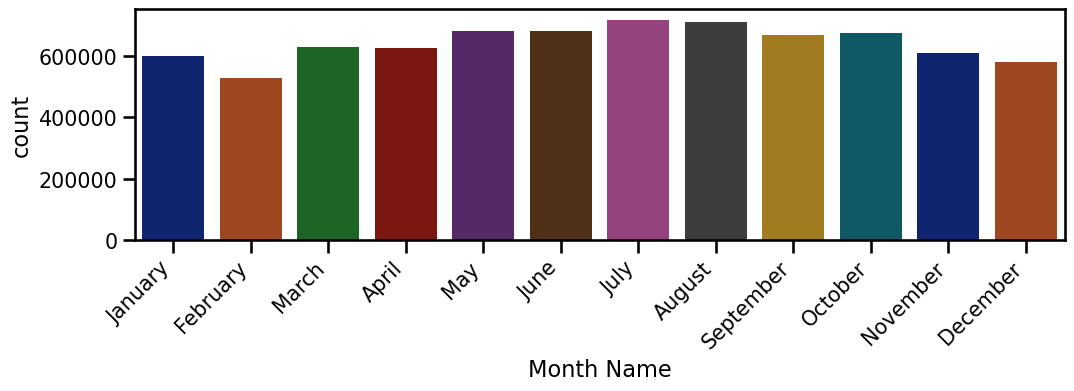

In [28]:
ax = sns.countplot(data=ts1, x='Month Name',palette='dark',order=month_lookup.values());
# Rotate xtick labels and align the text to the bar
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right');

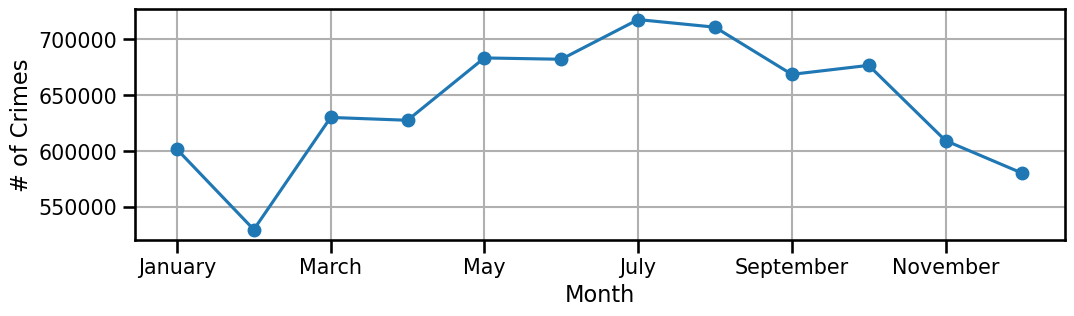

In [29]:
## save month counts
month_counts = ts1['Month Name'].value_counts()[month_lookup.values()]
# year_counts = df.groupby("Year").size()
ax = month_counts.plot(style='o-',grid=True,
                       ylabel='# of Crimes',
                       xlabel='Month');

In [30]:
crimes_by_month = ts1.groupby('Primary Type')['Month'].value_counts().sort_index()
crimes_by_month

Primary Type       Month
ARSON              1         917
                   2         807
                   3        1111
                   4        1097
                   5        1230
                            ... 
WEAPONS VIOLATION  8        9887
                   9        9435
                   10       9190
                   11       7952
                   12       7401
Name: Month, Length: 415, dtype: int64

In [31]:
# convert to dataframe
totals = crimes_by_month.to_frame('Crimes').reset_index()
totals

Primary Type  Month  Crimes
0                ARSON      1     917
1                ARSON      2     807
2                ARSON      3    1111
3                ARSON      4    1097
4                ARSON      5    1230
..                 ...    ...     ...
410  WEAPONS VIOLATION      8    9887
411  WEAPONS VIOLATION      9    9435
412  WEAPONS VIOLATION     10    9190
413  WEAPONS VIOLATION     11    7952
414  WEAPONS VIOLATION     12    7401

[415 rows x 3 columns]

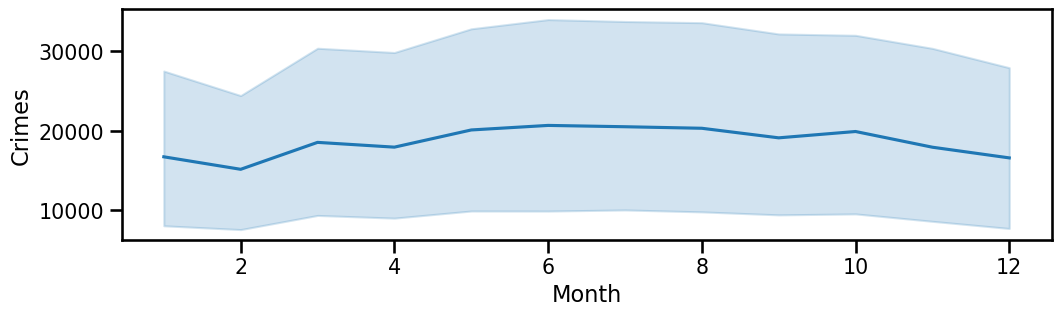

In [32]:
ax = sns.lineplot(data=totals, x='Month',y='Crimes')

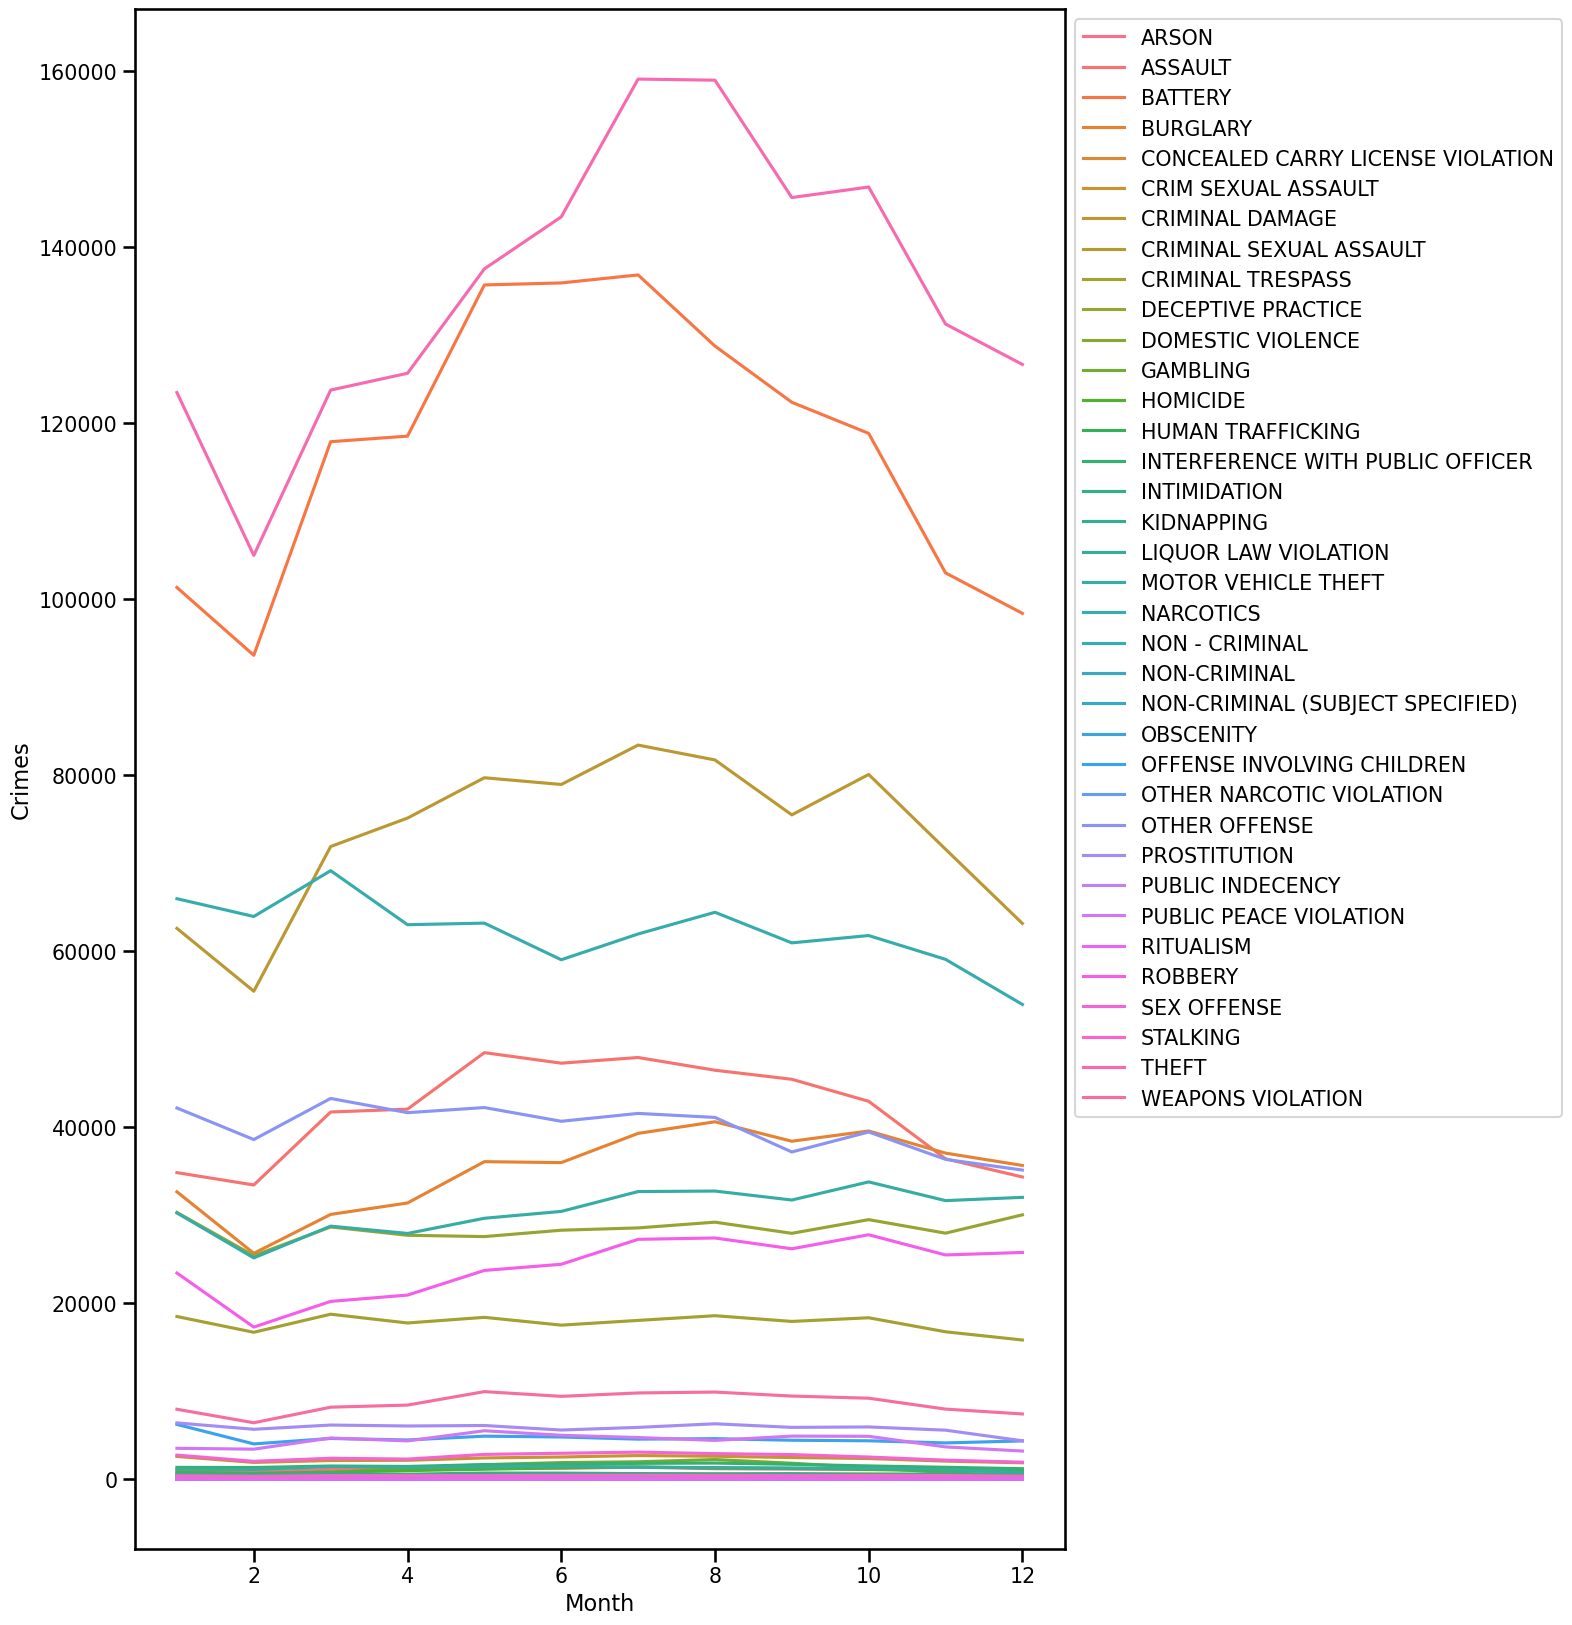

In [33]:
fig, ax = plt.subplots(figsize=(12,20))
sns.lineplot(data=totals, x='Month',y='Crimes',markers=True,
                  hue='Primary Type',ax=ax,)
ax.legend(bbox_to_anchor=[1,1]);

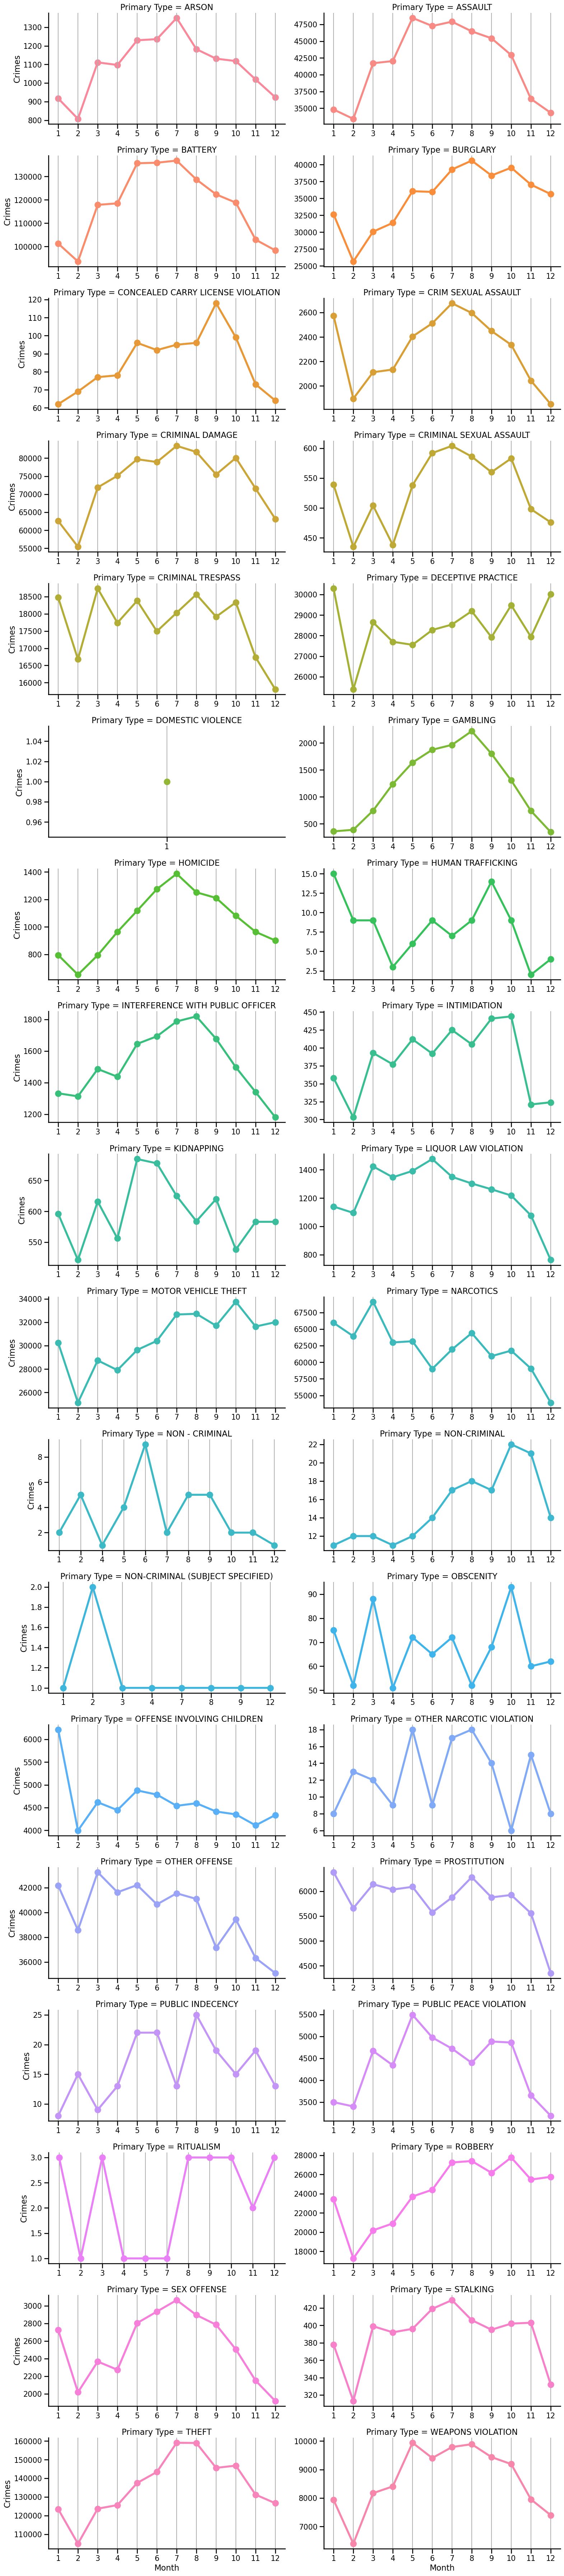

In [34]:
g = sns.catplot(data=totals, x='Month', y='Crimes',
                kind='point',aspect=2, height=4,
                hue='Primary Type', col='Primary Type',col_wrap=2,
               sharey=False, sharex=False)
[ax.grid(axis='x') for ax in g.axes];

### Topic 4) Comparing Months:

* ​What months have the most crime?
    * July and August are the months with the most crime
* What months have the least?
    * December and February are the months with the least.
* Are there any individual crimes that do not follow this pattern?
    * Yes, there are quite a few crimes with instances that peak in the winter
* If so, which crimes?
    * Offenses against children peaks in the January. Deceptive practices, criminal trespass peak in the winter months. Kidnapping peaks in the spring.
    * There is not enough information to accurately chart domestic violence crimes.

### Topic 2) Crimes Across the Years:

* ​Is the total number of crimes increasing or decreasing across the years?
* Are there any individual crimes that are doing the opposite (e.g., decreasing when overall crime is increasing or vice-versa)?

In [35]:
ts2 = ts.copy()
all_crimes = ts2[['Primary Type']]
df_resample = all_crimes.resample('A').count().copy()
df_resample

Primary Type
Date                    
2001-12-31        485886
2002-12-31        486807
2003-12-31        475985
2004-12-31        469422
2005-12-31        453773
2006-12-31        448179
2007-12-31        437087
2008-12-31        427183
2009-12-31        392827
2010-12-31        370513
2011-12-31        351993
2012-12-31        336319
2013-12-31        307536
2014-12-31        275789
2015-12-31        264787
2016-12-31        269823
2017-12-31        269100
2018-12-31        268899
2019-12-31        261325
2020-12-31        212194
2021-12-31        208824
2022-12-31        238858

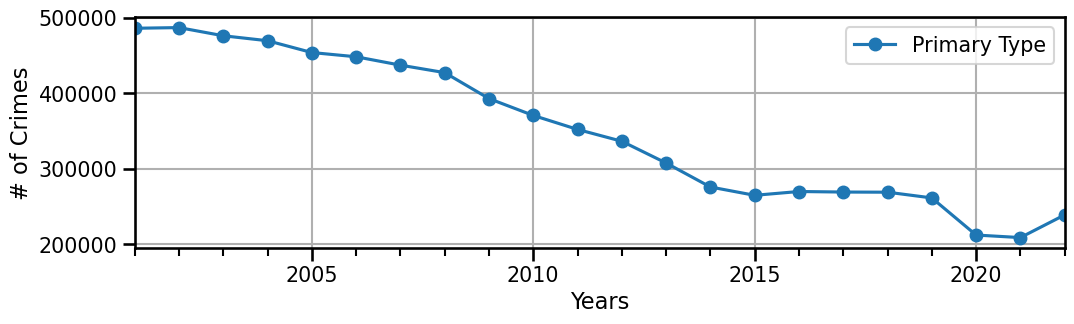

In [36]:
ax = df_resample.plot(style='o-',grid=True,
                       ylabel='# of Crimes',
                       xlabel='Years');

In [37]:
crimes_by_year = all_crimes.groupby('Primary Type').value_counts().sort_index()
crimes_by_year

Primary Type
ARSON                                  13121
ASSAULT                               501103
BATTERY                              1410889
BURGLARY                              422246
CONCEALED CARRY LICENSE VIOLATION       1019
CRIM SEXUAL ASSAULT                    27584
CRIMINAL DAMAGE                       878914
CRIMINAL SEXUAL ASSAULT                 6353
CRIMINAL TRESPASS                     212869
DECEPTIVE PRACTICE                    340958
DOMESTIC VIOLENCE                          1
GAMBLING                               14616
HOMICIDE                               12394
HUMAN TRAFFICKING                         96
INTERFERENCE WITH PUBLIC OFFICER       18206
INTIMIDATION                            4595
KIDNAPPING                              7185
LIQUOR LAW VIOLATION                   14846
MOTOR VEHICLE THEFT                   366586
NARCOTICS                             746155
NON - CRIMINAL                            38
NON-CRIMINAL                             1

In [38]:
ts2['Year'] = ts2.index.year
ts2.head()

ID     Primary Type          Description  \
Date                                                                 
2001-01-01 01:00:00  1326041          BATTERY               SIMPLE   
2001-01-01 01:00:00  1319931          BATTERY               SIMPLE   
2001-01-01 01:00:00  1324743         GAMBLING  ILLEGAL ILL LOTTERY   
2001-01-01 01:00:00  1310717  CRIMINAL DAMAGE           TO VEHICLE   
2001-01-01 01:00:00  1318099          BATTERY               SIMPLE   

                        Location Description  Arrest  Domestic  Beat  \
Date                                                                   
2001-01-01 01:00:00                RESIDENCE   False     False  1624   
2001-01-01 01:00:00                RESIDENCE   False      True   825   
2001-01-01 01:00:00                   STREET    True     False   313   
2001-01-01 01:00:00                   STREET   False     False  2424   
2001-01-01 01:00:00  RESIDENCE PORCH/HALLWAY   False      True   214   

                     District  Ward   Latitude  Longitude         Holiday  \
Date                                                                        
2001-01-01 01:00:00      16.0   NaN  41.957850 -87.749185  New Year's Day   
2001-01-01 01:00:00       8.0   NaN  41.783892 -87.684841  New Year's Day   
2001-01-01 01:00:00       3.0   NaN  41.780412 -87.611970  New Year's Day   
2001-01-01 01:00:00      24.0   NaN  42.012391 -87.678032  New Year's Day   
2001-01-01 01:00:00       2.0   NaN  41.819538 -87.620020  New Year's Day   

                     Year  
Date                       
2001-01-01 01:00:00  2001  
2001-01-01 01:00:00  2001  
2001-01-01 01:00:00  2001  
2001-01-01 01:00:00  2001  
2001-01-01 01:00:00  2001

In [39]:
year_ts2 = ts2.drop(columns=['ID', 'Description', 'Location Description',
                              'Arrest', 'Domestic', 'Beat', 'District', 'Ward',
                              'Latitude', 'Longitude', 'Holiday']).copy()
year_ts2

Primary Type  Year
Date                                         
2001-01-01 01:00:00             BATTERY  2001
2001-01-01 01:00:00             BATTERY  2001
2001-01-01 01:00:00            GAMBLING  2001
2001-01-01 01:00:00     CRIMINAL DAMAGE  2001
2001-01-01 01:00:00             BATTERY  2001
...                                 ...   ...
2022-12-31 12:50:00             ASSAULT  2022
2022-12-31 12:50:00             ASSAULT  2022
2022-12-31 12:52:00             BATTERY  2022
2022-12-31 12:52:00             ASSAULT  2022
2022-12-31 12:59:00  DECEPTIVE PRACTICE  2022

[7713109 rows x 2 columns]

In [40]:
year_ts2.index

DatetimeIndex(['2001-01-01 01:00:00', '2001-01-01 01:00:00',
               '2001-01-01 01:00:00', '2001-01-01 01:00:00',
               '2001-01-01 01:00:00', '2001-01-01 01:00:00',
               '2001-01-01 01:00:00', '2001-01-01 01:00:00',
               '2001-01-01 01:00:00', '2001-01-01 01:00:00',
               ...
               '2022-12-31 12:41:00', '2022-12-31 12:42:00',
               '2022-12-31 12:44:00', '2022-12-31 12:45:00',
               '2022-12-31 12:45:00', '2022-12-31 12:50:00',
               '2022-12-31 12:50:00', '2022-12-31 12:52:00',
               '2022-12-31 12:52:00', '2022-12-31 12:59:00'],
              dtype='datetime64[ns]', name='Date', length=7713109, freq=None)

In [41]:
by_year = year_ts2.groupby('Primary Type').resample('A').count()
by_year

Primary Type  Year
Primary Type      Date                          
ARSON             2001-12-31          1011  1011
                  2002-12-31          1032  1032
                  2003-12-31           955   955
                  2004-12-31           778   778
                  2005-12-31           691   691
...                                    ...   ...
WEAPONS VIOLATION 2018-12-31          5456  5456
                  2019-12-31          6339  6339
                  2020-12-31          8432  8432
                  2021-12-31          8980  8980
                  2022-12-31          8766  8766

[723 rows x 2 columns]

In [42]:
by_year.head().index

MultiIndex([('ARSON', '2001-12-31'),
            ('ARSON', '2002-12-31'),
            ('ARSON', '2003-12-31'),
            ('ARSON', '2004-12-31'),
            ('ARSON', '2005-12-31')],
           names=['Primary Type', 'Date'])

In [43]:
crime_yearly_totals = by_year.unstack(level=0)
crime_yearly_totals.head()

Primary Type                             \
Primary Type        ARSON  ASSAULT  BATTERY BURGLARY   
Date                                                   
2001-12-31         1011.0  31384.0  93461.0  26014.0   
2002-12-31         1032.0  31523.0  94153.0  25623.0   
2003-12-31          955.0  29477.0  88380.0  25157.0   
2004-12-31          778.0  28850.0  87136.0  24564.0   
2005-12-31          691.0  27067.0  83964.0  25503.0   

                                                                    \
Primary Type CONCEALED CARRY LICENSE VIOLATION CRIM SEXUAL ASSAULT   
Date                                                                 
2001-12-31                                 1.0              1779.0   
2002-12-31                                 0.0              1807.0   
2003-12-31                                 0.0              1571.0   
2004-12-31                                 0.0              1538.0   
2005-12-31                                 0.0              1521.0   

                                                                        \
Primary Type CRIMINAL DAMAGE CRIMINAL SEXUAL ASSAULT CRIMINAL TRESPASS   
Date                                                                     
2001-12-31           55859.0                    29.0           13241.0   
2002-12-31           55941.0                    27.0           13880.0   
2003-12-31           55011.0                    41.0           14807.0   
2004-12-31           53164.0                    42.0           15913.0   
2005-12-31           54548.0                    37.0           16655.0   

                                                                     \
Primary Type DECEPTIVE PRACTICE DOMESTIC VIOLENCE GAMBLING HOMICIDE   
Date                                                                  
2001-12-31              14949.0               1.0    934.0    667.0   
2002-12-31              13732.0               NaN    971.0    658.0   
2003-12-31              13459.0               NaN   1088.0    604.0   
2004-12-31              13255.0               NaN   1122.0    455.0   
2005-12-31              13590.0               NaN   1078.0    453.0   

                                                                              \
Primary Type HUMAN TRAFFICKING INTERFERENCE WITH PUBLIC OFFICER INTIMIDATION   
Date                                                                           
2001-12-31                 NaN                            406.0        279.0   
2002-12-31                 NaN                            361.0        337.0   
2003-12-31                 NaN                            409.0        364.0   
2004-12-31                 NaN                            531.0        349.0   
2005-12-31                 NaN                            615.0        258.0   

                                                                            \
Primary Type KIDNAPPING LIQUOR LAW VIOLATION MOTOR VEHICLE THEFT NARCOTICS   
Date                                                                         
2001-12-31        933.0               1637.0             27553.0   50567.0   
2002-12-31        829.0               1414.0             25121.0   51789.0   
2003-12-31        705.0               1311.0             22748.0   54288.0   
2004-12-31        482.0                985.0             22805.0   57060.0   
2005-12-31        389.0               1005.0             22497.0   56234.0   

                                                                           \
Primary Type NON - CRIMINAL NON-CRIMINAL NON-CRIMINAL (SUBJECT SPECIFIED)   
Date                                                                        
2001-12-31              NaN          NaN                              NaN   
2002-12-31              NaN          NaN                              NaN   
2003-12-31              NaN          1.0                              NaN   
2004-12-31              NaN          0.0                              NaN   
2005-12-31              NaN         

In [44]:
crime_yearly_totals['Primary Type'].value_counts()

Series([], dtype: int64)

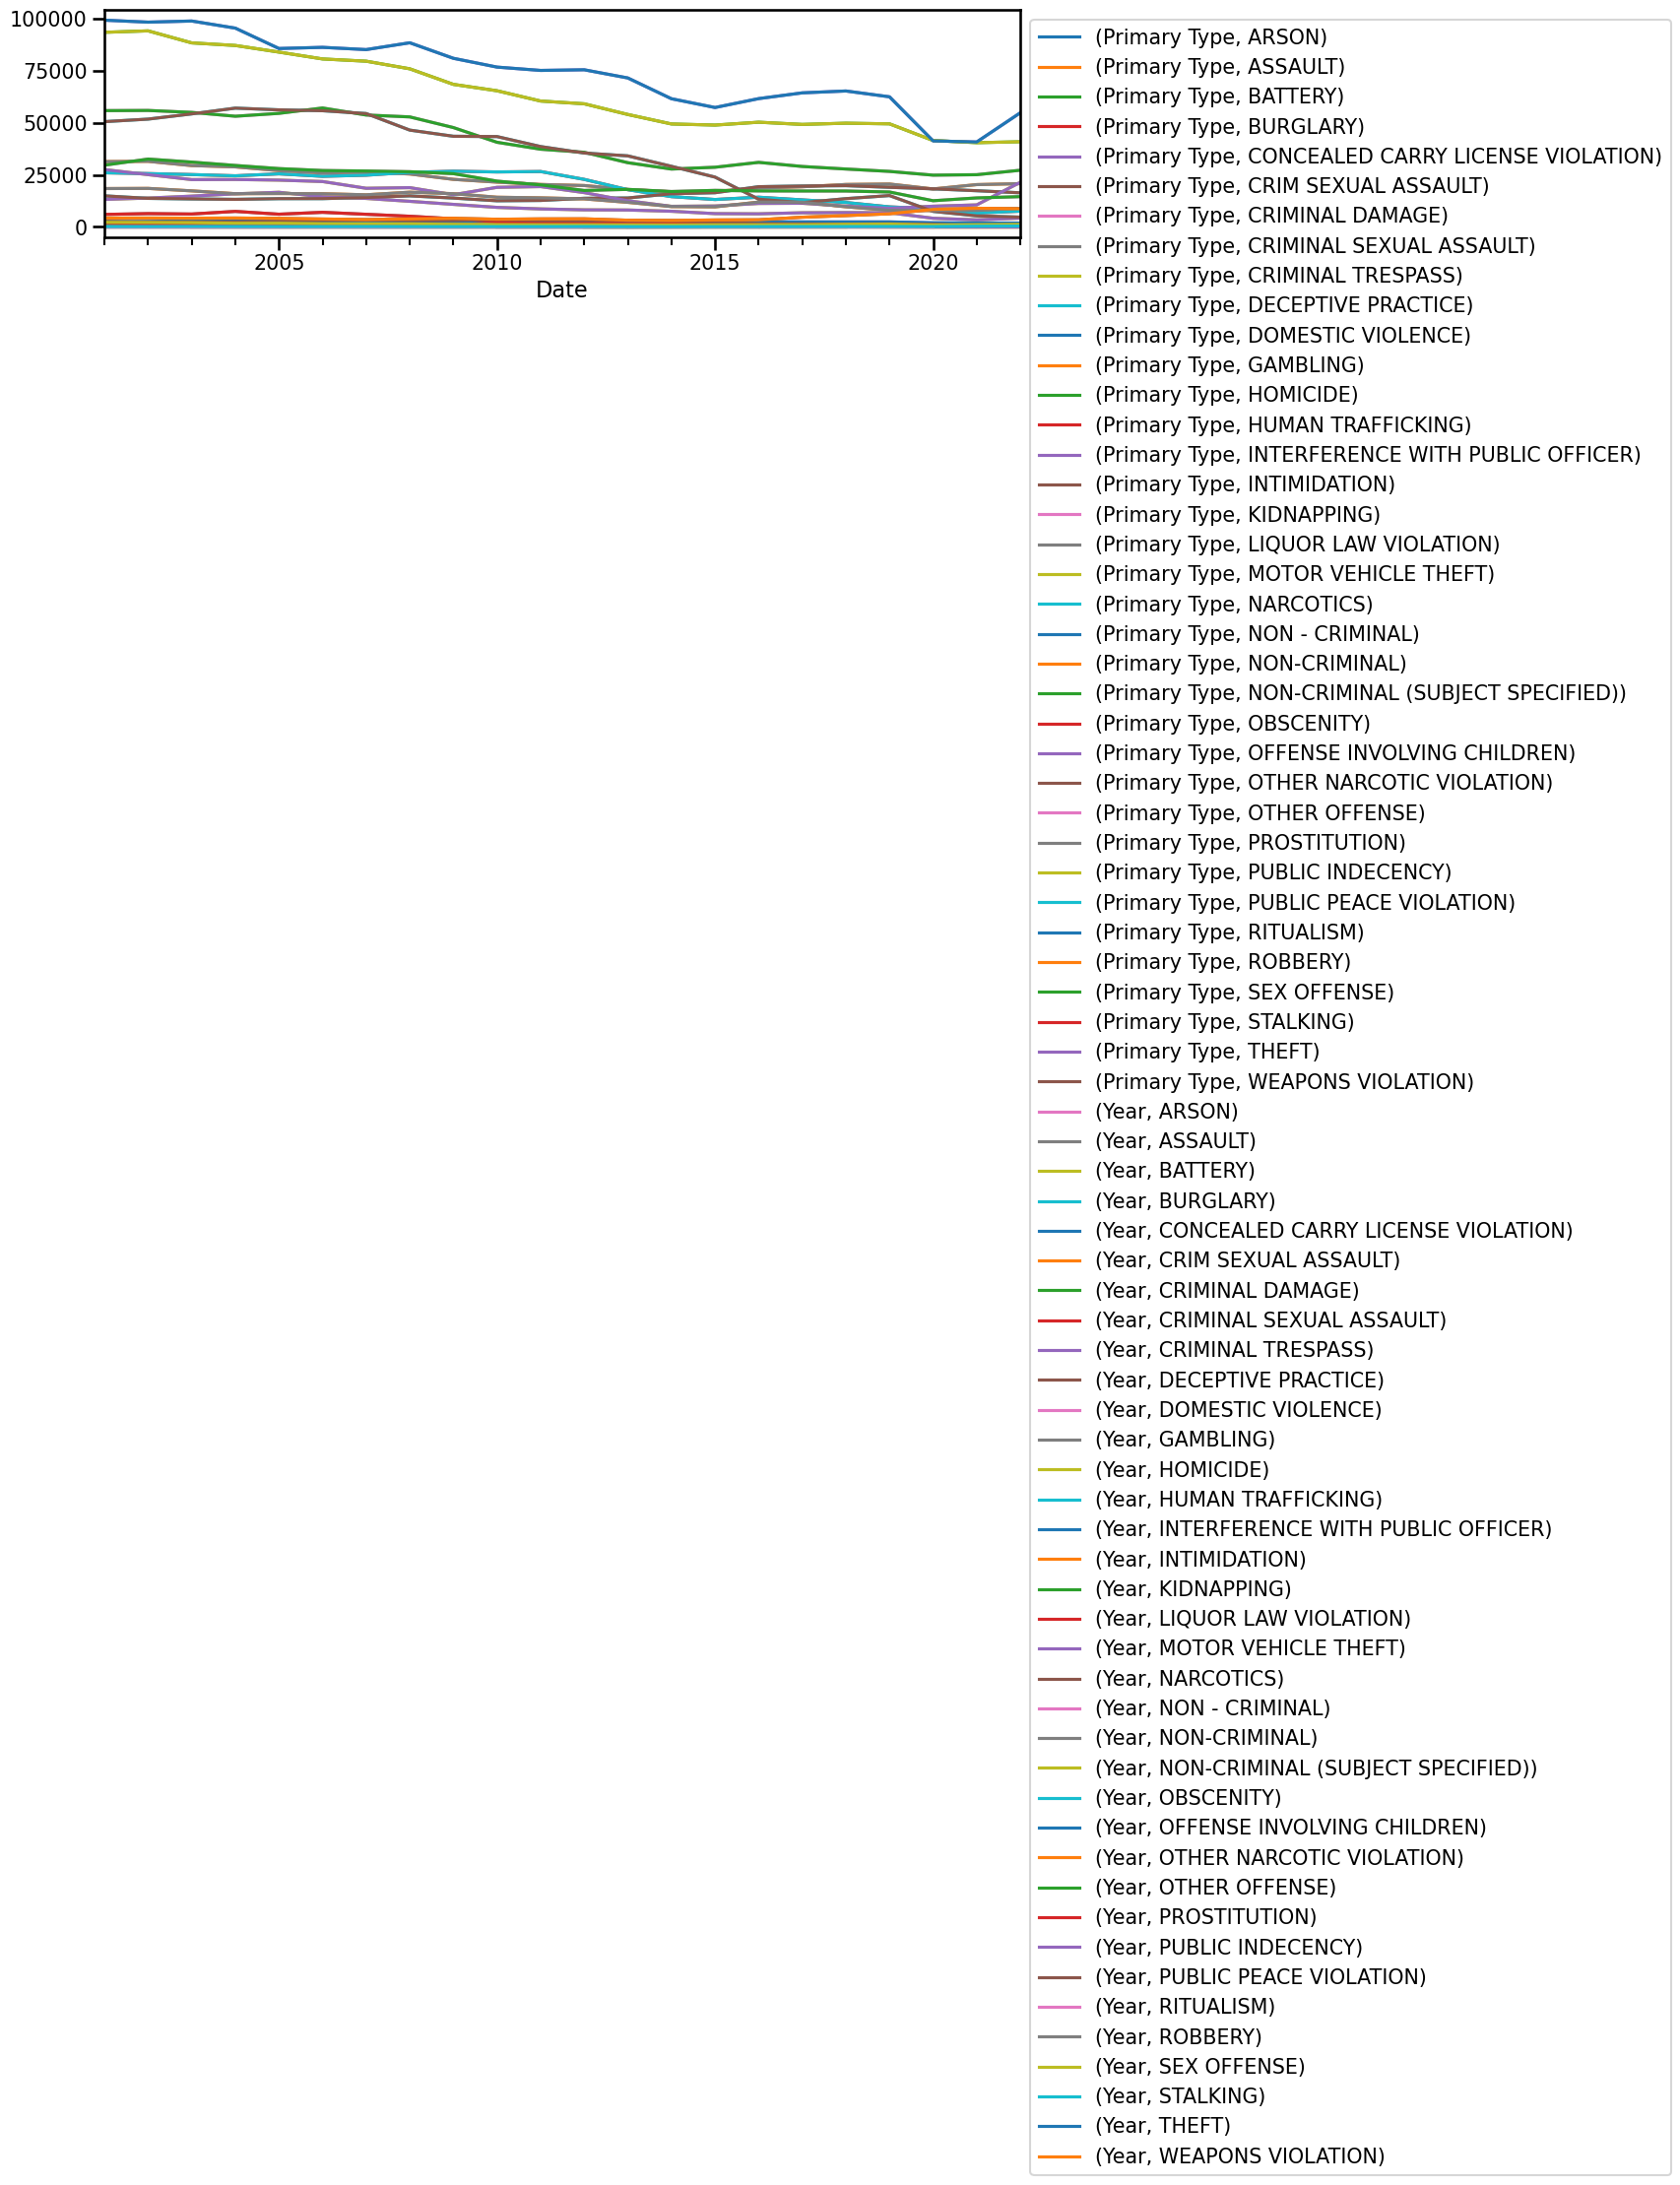

In [45]:
ax = crime_yearly_totals.plot()
plt.legend(bbox_to_anchor=(1,1));

In [46]:
cyt = ts2.groupby('Primary Type')['Year'].value_counts().sort_index()
cyt

Primary Type       Year
ARSON              2001    1011
                   2002    1032
                   2003     955
                   2004     778
                   2005     691
                           ... 
WEAPONS VIOLATION  2018    5456
                   2019    6339
                   2020    8432
                   2021    8980
                   2022    8766
Name: Year, Length: 689, dtype: int64

In [47]:
plot_cyt = cyt.to_frame('Crimes').reset_index()
plot_cyt

Primary Type  Year  Crimes
0                ARSON  2001    1011
1                ARSON  2002    1032
2                ARSON  2003     955
3                ARSON  2004     778
4                ARSON  2005     691
..                 ...   ...     ...
684  WEAPONS VIOLATION  2018    5456
685  WEAPONS VIOLATION  2019    6339
686  WEAPONS VIOLATION  2020    8432
687  WEAPONS VIOLATION  2021    8980
688  WEAPONS VIOLATION  2022    8766

[689 rows x 3 columns]

In [48]:
plot_cyt['Primary Type'].value_counts()

ARSON                                22
KIDNAPPING                           22
THEFT                                22
STALKING                             22
SEX OFFENSE                          22
ROBBERY                              22
PUBLIC PEACE VIOLATION               22
PUBLIC INDECENCY                     22
PROSTITUTION                         22
OTHER OFFENSE                        22
OTHER NARCOTIC VIOLATION             22
OFFENSE INVOLVING CHILDREN           22
OBSCENITY                            22
NARCOTICS                            22
ASSAULT                              22
LIQUOR LAW VIOLATION                 22
MOTOR VEHICLE THEFT                  22
INTIMIDATION                         22
INTERFERENCE WITH PUBLIC OFFICER     22
BATTERY                              22
BURGLARY                             22
CRIMINAL DAMAGE                      22
CRIMINAL SEXUAL ASSAULT              22
CRIMINAL TRESPASS                    22
DECEPTIVE PRACTICE                   22


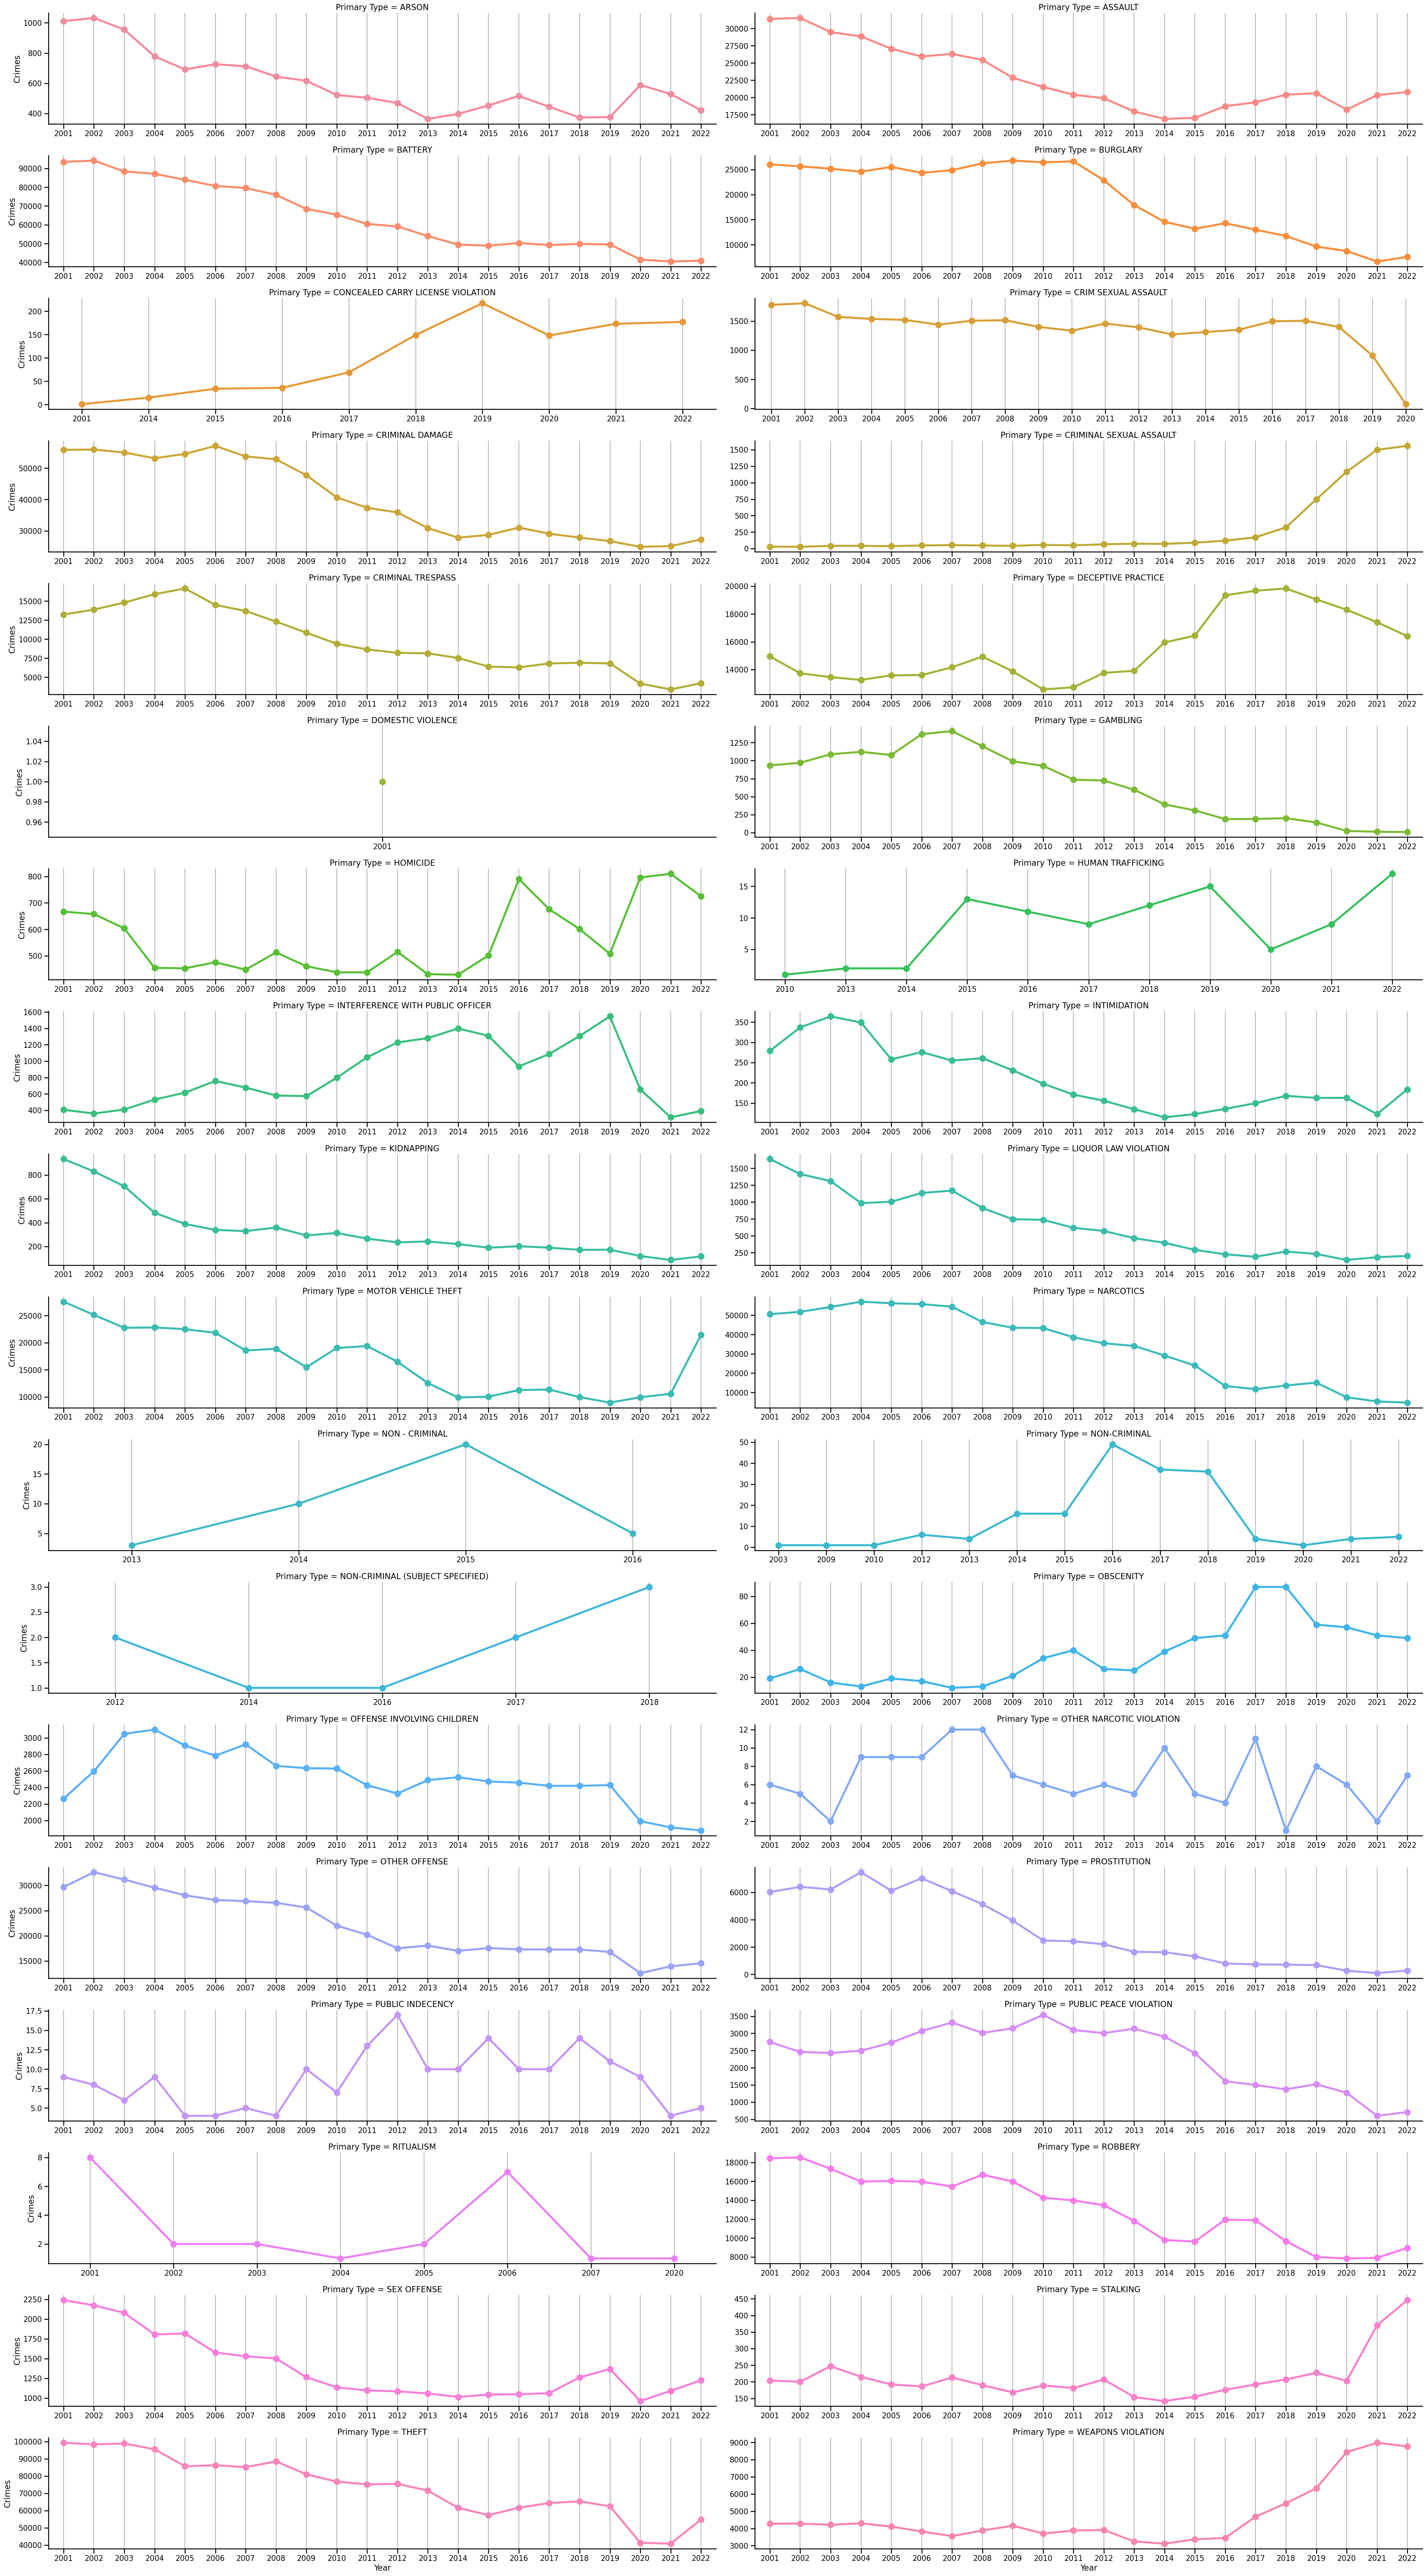

In [49]:
h = sns.catplot(data=plot_cyt, x='Year', y='Crimes',
                kind='point',aspect=5, height=4,
                hue='Primary Type', col='Primary Type',col_wrap=2,
               sharey=False, sharex=False)
[ax.grid(axis='x') for ax in h.axes];

### Topic 2) Crimes Across the Years:

* ​Is the total number of crimes increasing or decreasing across the years?
* The total number of crimes is decreasing overall.
* Are there any individual crimes that are doing the opposite (e.g., decreasing when overall crime is increasing or vice-versa)?
* Yes, human trafficking, criminal sexual assault, motor vehicle theft and stalking are showing marked rise in the trend.

# PART TWO

In [50]:
ts.head()

ID     Primary Type          Description  \
Date                                                                 
2001-01-01 01:00:00  1326041          BATTERY               SIMPLE   
2001-01-01 01:00:00  1319931          BATTERY               SIMPLE   
2001-01-01 01:00:00  1324743         GAMBLING  ILLEGAL ILL LOTTERY   
2001-01-01 01:00:00  1310717  CRIMINAL DAMAGE           TO VEHICLE   
2001-01-01 01:00:00  1318099          BATTERY               SIMPLE   

                        Location Description  Arrest  Domestic  Beat  \
Date                                                                   
2001-01-01 01:00:00                RESIDENCE   False     False  1624   
2001-01-01 01:00:00                RESIDENCE   False      True   825   
2001-01-01 01:00:00                   STREET    True     False   313   
2001-01-01 01:00:00                   STREET   False     False  2424   
2001-01-01 01:00:00  RESIDENCE PORCH/HALLWAY   False      True   214   

                     District  Ward   Latitude  Longitude         Holiday  
Date                                                                       
2001-01-01 01:00:00      16.0   NaN  41.957850 -87.749185  New Year's Day  
2001-01-01 01:00:00       8.0   NaN  41.783892 -87.684841  New Year's Day  
2001-01-01 01:00:00       3.0   NaN  41.780412 -87.611970  New Year's Day  
2001-01-01 01:00:00      24.0   NaN  42.012391 -87.678032  New Year's Day  
2001-01-01 01:00:00       2.0   NaN  41.819538 -87.620020  New Year's Day

In [51]:
cc = ts.drop(columns = ['ID', 'Location Description', 'Arrest', 'Domestic', 'Beat', 'Description', 'Ward', 'Latitude', 'Longitude']).copy()
cc

Primary Type  District         Holiday
Date                                                             
2001-01-01 01:00:00             BATTERY      16.0  New Year's Day
2001-01-01 01:00:00             BATTERY       8.0  New Year's Day
2001-01-01 01:00:00            GAMBLING       3.0  New Year's Day
2001-01-01 01:00:00     CRIMINAL DAMAGE      24.0  New Year's Day
2001-01-01 01:00:00             BATTERY       2.0  New Year's Day
...                                 ...       ...             ...
2022-12-31 12:50:00             ASSAULT      10.0            None
2022-12-31 12:50:00             ASSAULT       7.0            None
2022-12-31 12:52:00             BATTERY      11.0            None
2022-12-31 12:52:00             ASSAULT      14.0            None
2022-12-31 12:59:00  DECEPTIVE PRACTICE      15.0            None

[7713109 rows x 3 columns]

In [52]:
cc.isna().sum()

Primary Type          0
District             47
Holiday         7437180
dtype: int64

In [54]:
cc_2 = cc.groupby('Primary Type').resample('M').size()
cc_2

Primary Type       Date      
ARSON              2001-01-31     67
                   2001-02-28     57
                   2001-03-31     93
                   2001-04-30     89
                   2001-05-31     94
                                ... 
WEAPONS VIOLATION  2022-08-31    832
                   2022-09-30    780
                   2022-10-31    735
                   2022-11-30    597
                   2022-12-31    543
Length: 8602, dtype: int64

In [55]:
cc_2.index

MultiIndex([(            'ARSON', '2001-01-31'),
            (            'ARSON', '2001-02-28'),
            (            'ARSON', '2001-03-31'),
            (            'ARSON', '2001-04-30'),
            (            'ARSON', '2001-05-31'),
            (            'ARSON', '2001-06-30'),
            (            'ARSON', '2001-07-31'),
            (            'ARSON', '2001-08-31'),
            (            'ARSON', '2001-09-30'),
            (            'ARSON', '2001-10-31'),
            ...
            ('WEAPONS VIOLATION', '2022-03-31'),
            ('WEAPONS VIOLATION', '2022-04-30'),
            ('WEAPONS VIOLATION', '2022-05-31'),
            ('WEAPONS VIOLATION', '2022-06-30'),
            ('WEAPONS VIOLATION', '2022-07-31'),
            ('WEAPONS VIOLATION', '2022-08-31'),
            ('WEAPONS VIOLATION', '2022-09-30'),
            ('WEAPONS VIOLATION', '2022-10-31'),
            ('WEAPONS VIOLATION', '2022-11-30'),
            ('WEAPONS VIOLATION', '2022-12-31')],
   

In [85]:
unstacked_cc = cc_2.unstack(level=0)
unstacked_cc

Primary Type  ARSON  ASSAULT  BATTERY  BURGLARY  \
Date                                              
2001-01-31     67.0   2123.0   6527.0    1934.0   
2001-02-28     57.0   2029.0   6042.0    1666.0   
2001-03-31     93.0   2824.0   7662.0    1832.0   
2001-04-30     89.0   2746.0   8328.0    1932.0   
2001-05-31     94.0   2903.0   8887.0    1997.0   
...             ...      ...      ...       ...   
2022-08-31     40.0   1984.0   3740.0     674.0   
2022-09-30     49.0   1891.0   3723.0     653.0   
2022-10-31     41.0   1839.0   3501.0     688.0   
2022-11-30     29.0   1659.0   3083.0     677.0   
2022-12-31     35.0   1569.0   3009.0     695.0   

Primary Type  CONCEALED CARRY LICENSE VIOLATION  CRIM SEXUAL ASSAULT  \
Date                                                                   
2001-01-31                                  NaN                162.0   
2001-02-28                                  NaN                134.0   
2001-03-31                                  NaN                149.0   
2001-04-30                                  NaN                132.0   
2001-05-31                                  1.0                155.0   
...                                         ...                  ...   
2022-08-31                                 15.0                  NaN   
2022-09-30                                 13.0                  NaN   
2022-10-31                                 10.0                  NaN   
2022-11-30                                 18.0                  NaN   
2022-12-31                                 12.0                  NaN   

Primary Type  CRIMINAL DAMAGE  CRIMINAL SEXUAL ASSAULT  CRIMINAL TRESPASS  \
Date                                                                        
2001-01-31             3966.0                      3.0             1192.0   
2001-02-28             3665.0                      1.0             1063.0   
2001-03-31             4617.0                      4.0             1141.0   
2001-04-30             4922.0                      2.0             1133.0   
2001-05-31             4757.0                      2.0             1067.0   
...                       ...                      ...                ...   
2022-08-31             2713.0                    145.0              392.0   
2022-09-30             2619.0                    144.0              378.0   
2022-10-31             2834.0                    162.0              374.0   
2022-11-30             2459.0                    109.0              331.0   
2022-12-31             2264.0                     91.0              341.0   

Primary Type  DECEPTIVE PRACTICE  DOMESTIC VIOLENCE  GAMBLING  HOMICIDE  \
Date                                                                      
2001-01-31                1398.0                1.0      44.0      42.0   
2001-02-28                1163.0                NaN      37.0      27.0   
2001-03-31                1313.0                NaN      55.0      37.0   
2001-04-30                1199.0                NaN      79.0      59.0   
2001-05-31                1261.0                NaN      94.0      42.0   
...                          ...                ...       ...       ...   
2022-08-31                1432.0                NaN       2.0      69.0   
2022-09-30                1540.0                NaN       NaN      75.0   
2022-10-31                1568.0                NaN       NaN      65.0   
2022-11-30                1421.0                NaN       NaN      57.0   
2022-12-31                1438.0                NaN       NaN      60.0   

Primary Type  HUMAN TRAFFICKING  INTERFERENCE WITH PUBLIC OFFICER  \
Date                                                                
2001-01-31                  NaN                              36.0   
2001-02-28                  NaN                              27.0   
2001-03-31                  NaN                              22.0   
2001-04-30                  NaN                              34.0   
2001-05

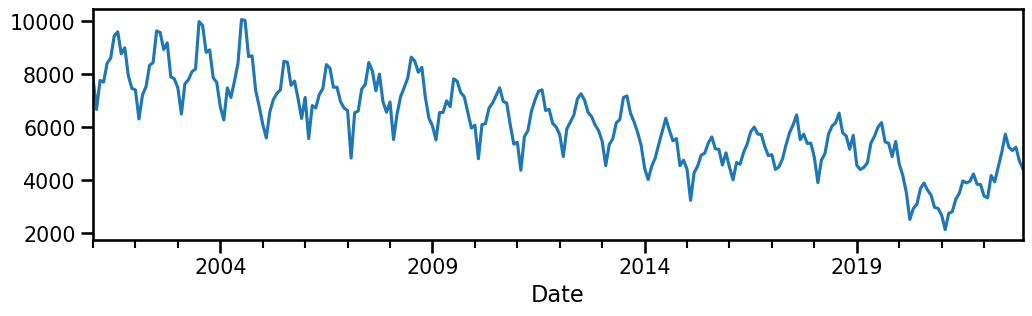

In [57]:
cc_t = unstacked_cc['THEFT']
ax = cc_t.plot()

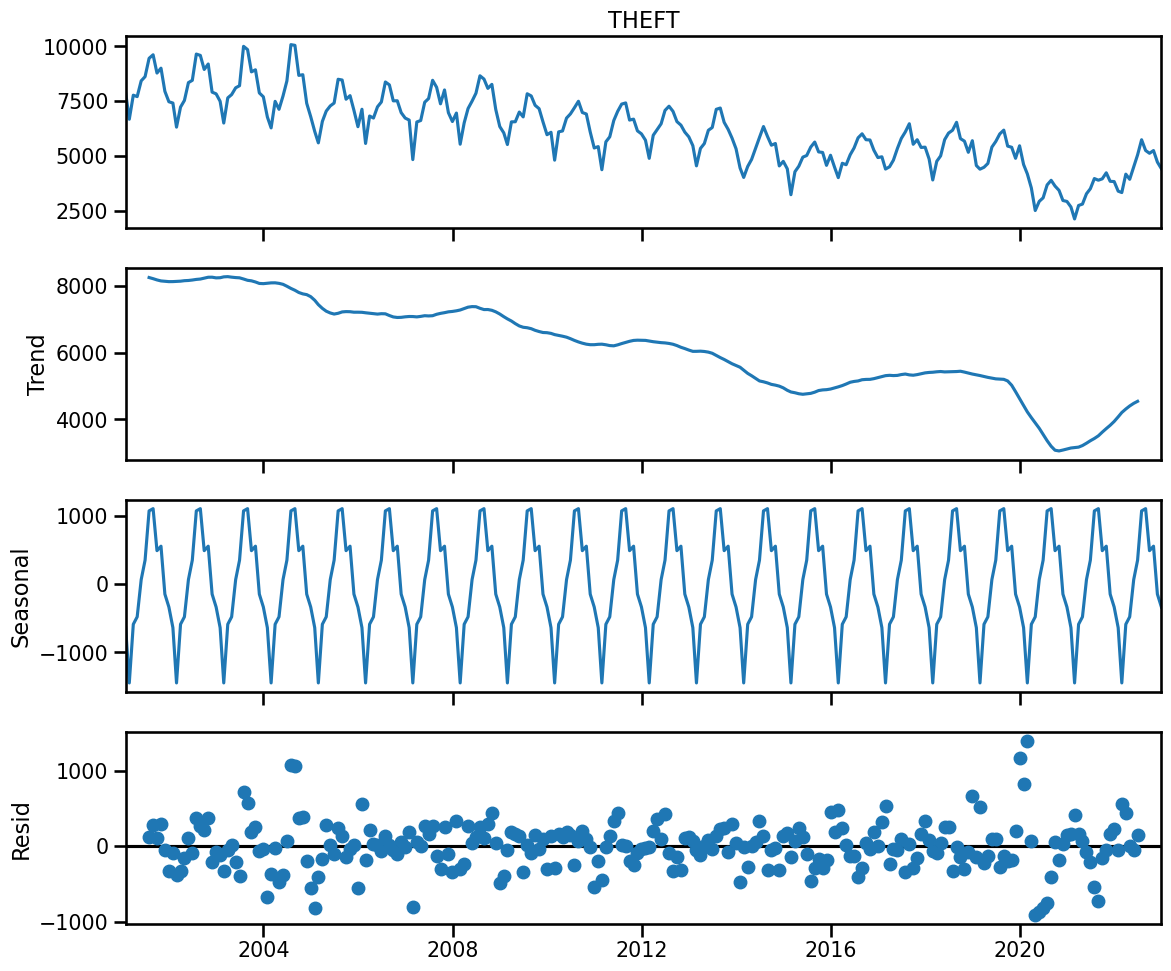

In [58]:
decomp = tsa.seasonal_decompose(cc_t)
fig = decomp.plot()
fig.set_size_inches(12,10)
fig.tight_layout()

In [59]:
tmax = cc_t.max()
tmin = cc_t.min()
seasonal_delta = decomp.seasonal.max() - decomp.seasonal.min()
tper = seasonal_delta/(tmax-tmin) * 100

print(f"The seasonal component is {seasonal_delta} which is ~{tper:.2f}% of the variation in time series.")

The seasonal component is 2549.9880952380954 which is ~32.08% of the variation in time series.


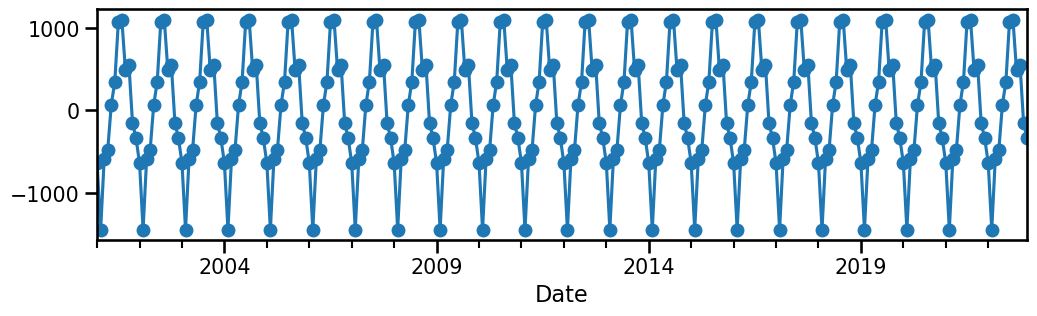

In [60]:
seasonal = decomp.seasonal
ax = seasonal.plot(marker = 'o')

In [61]:
# determine d
d = ndiffs(cc_t)
print (f'd = {d}')

d = 1


In [62]:
# Determine D
D = nsdiffs(cc_t, m =12)
print(f'D = {D}')

D = 0


In [63]:
# Difference the data
t_diff = cc_t.diff().dropna()

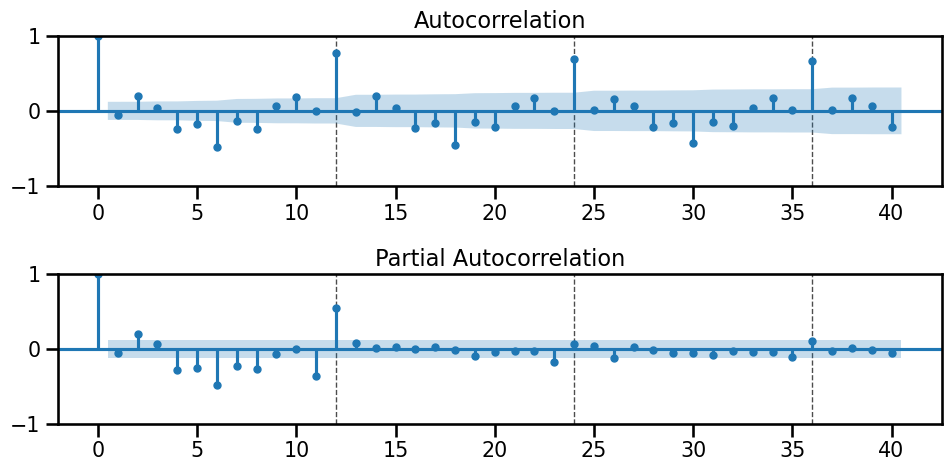

In [64]:
plot_acf_pacf(t_diff, annotate_seas=True, m = 12);

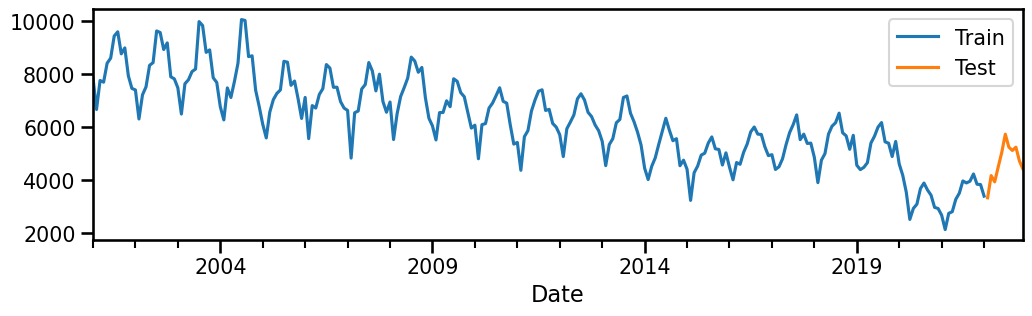

In [65]:
train_t, test_t = train_test_split(cc_t, test_size=.04)
ax = train_t.plot(label='Train')
test_t.plot(ax=ax, label='Test')
ax.legend();

In [66]:
# non-seasonal
p = 1
d = 0
q = 1
# seasonal
P = 1
D = 0
Q = 1
m = 12

sarima = tsa.ARIMA(train_t, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 1,054.432
- MSE = 1,192,890.965
- RMSE = 1,092.195
- R^2 = -1.714
- MAPE = 22.21%


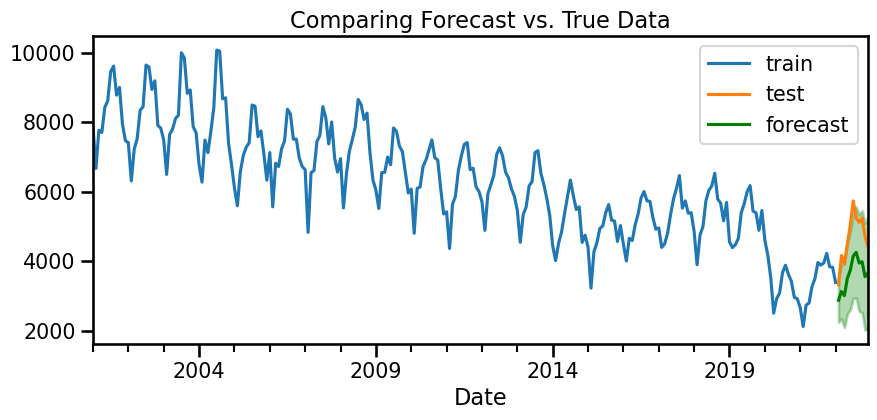

In [67]:
forecast_df = sarima.get_forecast(len(test_t)).summary_frame()
plot_forecast(train_t, test_t, forecast_df)
regression_metrics_ts(test_t, forecast_df["mean"])

In [68]:
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                            THEFT   No. Observations:                  253
Model:             ARIMA(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood               -1836.774
Date:                          Fri, 08 Dec 2023   AIC                           3685.549
Time:                                  14:46:21   BIC                           3706.749
Sample:                              01-31-2001   HQIC                          3694.078
                                   - 01-31-2022                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6227.4964     28.485    218.627      0.000    6171.668    6283.325
ar.L1          0.9999      0.000   3677.778      0.000       0.999       1.000
ma.L1         -0.2605      0.045     -5.742      0.000      -0.349      -0.172
ar.S.L12       0.9802      0.008    116.492      0.000       0.964       0.997
ma.S.L12      -0.6540      0.048    -13.532      0.000      -0.749      -0.559
sigma2      1.039e+05   6934.733     14.980      0.000    9.03e+04    1.17e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                48.96
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                            -0.36
Prob(H) (two-sided):                  0.76   Kurtosis:                         5.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.48e+17. Standard errors may be unstable.
"""

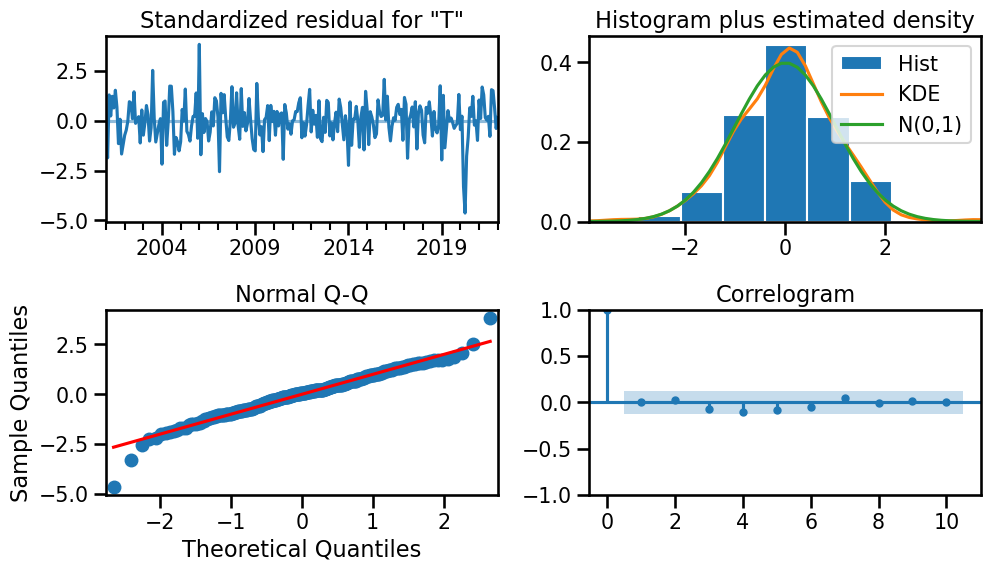

In [69]:
# Obtain diagnostic plots
fig = sarima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

In [70]:
# Define the value or range of values for p, d, q
p_values = range(0, 3)
d_values = [1]
q_values = range(0, 3)
P_values = range (0, 3)
D_values = [0]
Q_values = range (0,3)
m = [12]

# Create combinations of pdq to test
pdqPDQm_to_try = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, m))

# Display first 10 combinations
pdqPDQm_to_try[:10]

[(0, 1, 0, 0, 0, 0, 12),
 (0, 1, 0, 0, 0, 1, 12),
 (0, 1, 0, 0, 0, 2, 12),
 (0, 1, 0, 1, 0, 0, 12),
 (0, 1, 0, 1, 0, 1, 12),
 (0, 1, 0, 1, 0, 2, 12),
 (0, 1, 0, 2, 0, 0, 12),
 (0, 1, 0, 2, 0, 1, 12),
 (0, 1, 0, 2, 0, 2, 12),
 (0, 1, 1, 0, 0, 0, 12)]

In [71]:
# define starting aic as infinity
best_aic = float("inf")

# define baseline for pdq
best_pdqPDQm = (0,0,0,0,0,0,0)

# Loop through each combination
for pdqPDQm in pdqPDQm_to_try:
    order = pdqPDQm[:3] # first three values are non seasonal (p,d,q)
    seasonal_order = pdqPDQm[3:] # Remaining values for seasonal (P,D,Q,m)

    model = tsa.ARIMA(train_t, order=order, seasonal_order = seasonal_order)
    try:
        result = model.fit()
        print(pdqPDQm, result.aic)

    except:
        print(f'{pdqPDQm}: caused an error')

    # If lower, replace best AIC with new value
    if result.aic < best_aic:

        best_aic = result.aic
        best_pdqPDQm = pdqPDQm

# Print the best orders and AIC score
print("Best AIC:", best_aic)
print("Best pdqPDQm:", best_pdqPDQm)

(0, 1, 0, 0, 0, 0, 12) 3971.434555956209
(0, 1, 0, 0, 0, 1, 12) 3839.5055732836217
(0, 1, 0, 0, 0, 2, 12) 3800.0065041165826
(0, 1, 0, 1, 0, 0, 12) 3727.4317730162084
(0, 1, 0, 1, 0, 1, 12) 3681.4881149765642
(0, 1, 0, 1, 0, 2, 12) 3681.026088403115
(0, 1, 0, 2, 0, 0, 12) 3709.1988043363685
(0, 1, 0, 2, 0, 1, 12) 3681.80618444005
(0, 1, 0, 2, 0, 2, 12) 3681.1092614012014
(0, 1, 1, 0, 0, 0, 12) 3972.232382922107
(0, 1, 1, 0, 0, 1, 12) 3838.10208018941
(0, 1, 1, 0, 0, 2, 12) 3796.7381876609647
(0, 1, 1, 1, 0, 0, 12) 3718.15303756308
(0, 1, 1, 1, 0, 1, 12) 3667.9566000696605
(0, 1, 1, 1, 0, 2, 12) 3668.1776574275664
(0, 1, 1, 2, 0, 0, 12) 3697.238699415733
(0, 1, 1, 2, 0, 1, 12) 3668.7573456004993
(0, 1, 1, 2, 0, 2, 12): caused an error
(0, 1, 2, 0, 0, 0, 12) 3952.8230979451155
(0, 1, 2, 0, 0, 1, 12) 3831.5323965561383
(0, 1, 2, 0, 0, 2, 12) 3792.9831933210226
(0, 1, 2, 1, 0, 0, 12) 3719.8761264855475
(0, 1, 2, 1, 0, 1, 12) 3669.9193136079784
(0, 1, 2, 1, 0, 2, 12) 3670.1436529764783
(0, 

In [72]:
# auto_arima
auto_model = pm.auto_arima(
    train_t,
    seasonal=True,
    m=12,
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.50 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3973.237, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3719.583, Time=0.28 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3839.974, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3971.435, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=3973.516, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=3698.314, Time=0.90 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=3672.313, Time=1.58 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=3669.275, Time=0.60 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=3839.082, Time=0.22 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=3669.568, Time=1.34 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=3797.442, Time=0.59 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=2.10 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=3682.798, Time=0.56 sec
 ARIMA(2,1,0)(1,0,1)[12] inte

In [73]:
# Orders for non seasonal components
p = 1 # nonseasonal AR
d = 1  # nonseasonal differencing
q = 0  # nonseasonal MA
# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period
sarima = tsa.ARIMA(train_t, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 1,058.375
- MSE = 1,203,696.944
- RMSE = 1,097.131
- R^2 = -1.739
- MAPE = 22.28%


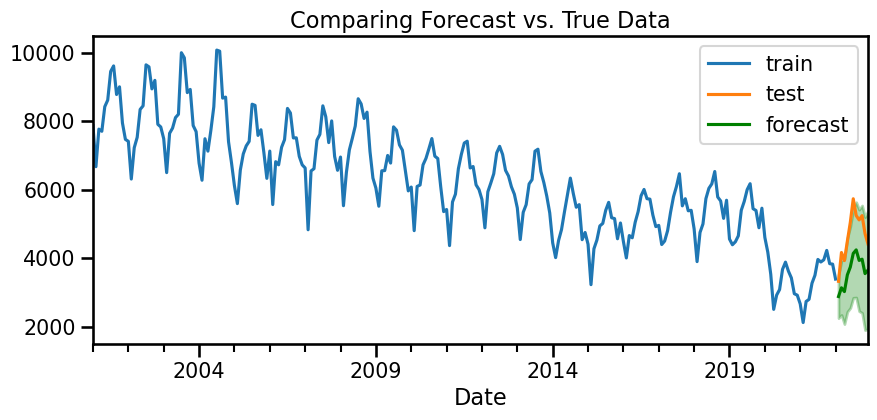

In [74]:
forecast_df = sarima.get_forecast(len(test_t)).summary_frame()
plot_forecast(train_t, test_t, forecast_df)
regression_metrics_ts(test_t, forecast_df["mean"])

####  ***Model Choice : Theft***
Best model:
ARIMA(1,1,0)(1,0,1)[12]

**Regression Metrics:**

- MAE =1058.375
- MSE = 1,203,696.944
- RMSE = 1,097.131
- R^2 = -1.739
- MAPE = 22.28%

In [75]:
len(test_t)

11

In [76]:
# Final model
# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 0 # nonseasonal MA

# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

final_model_t = tsa.ARIMA(train_t, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

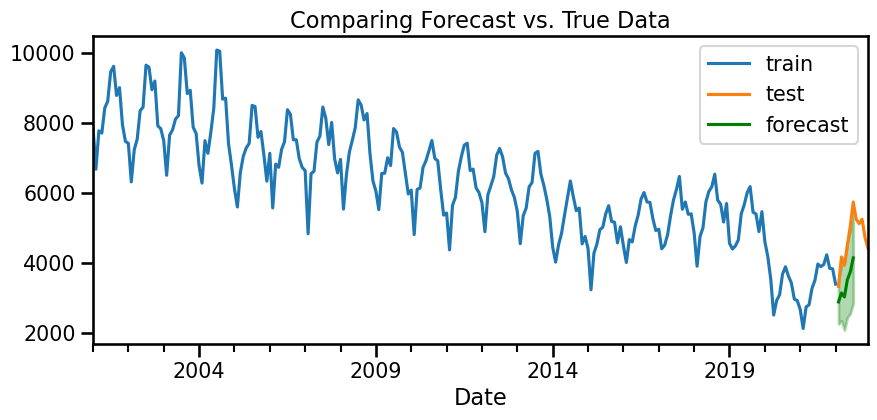

In [77]:
forecast_df_t  = final_model_t.get_forecast(6).summary_frame()
plot_forecast(train_t,test_t,forecast_df_t);

In [78]:
forecast_df_t.index[0],forecast_df_t.index[-1]

(Timestamp('2022-02-28 00:00:00', freq='M'),
 Timestamp('2022-07-31 00:00:00', freq='M'))

In [79]:
starting_value_t = forecast_df_t['mean'].iloc[0]
starting_value_t

2881.6842375260694

In [80]:
final_value_t = forecast_df_t['mean'].iloc[-1]
final_value_t

4139.375746606256

In [81]:
change_t = final_value_t - starting_value_t
change_t

1257.6915090801867

In [82]:
perc_change_t = (change_t / starting_value_t) * 100
perc_change_t

43.64432066158355

###### Change Theft
The total Predicted increase in Theft over the six month period after the data set is:
- Raw Increase = ~1257
- Percentage change = ~43.6%

## Narcotics

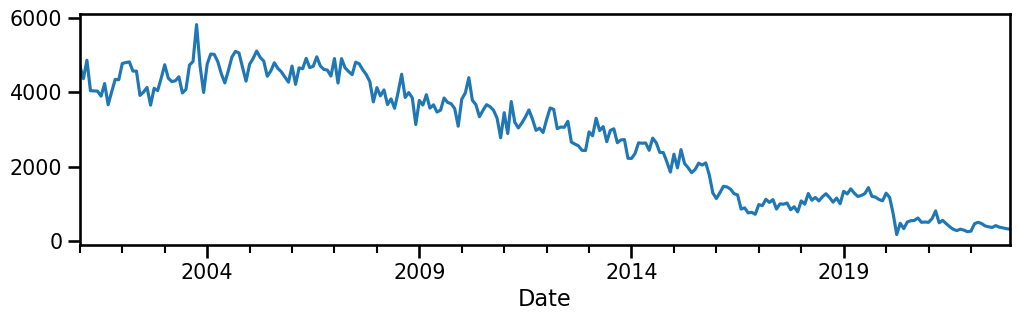

In [87]:
narc = unstacked_cc['NARCOTICS']
ax = narc.plot()

In [88]:
narc.isna().sum()

0

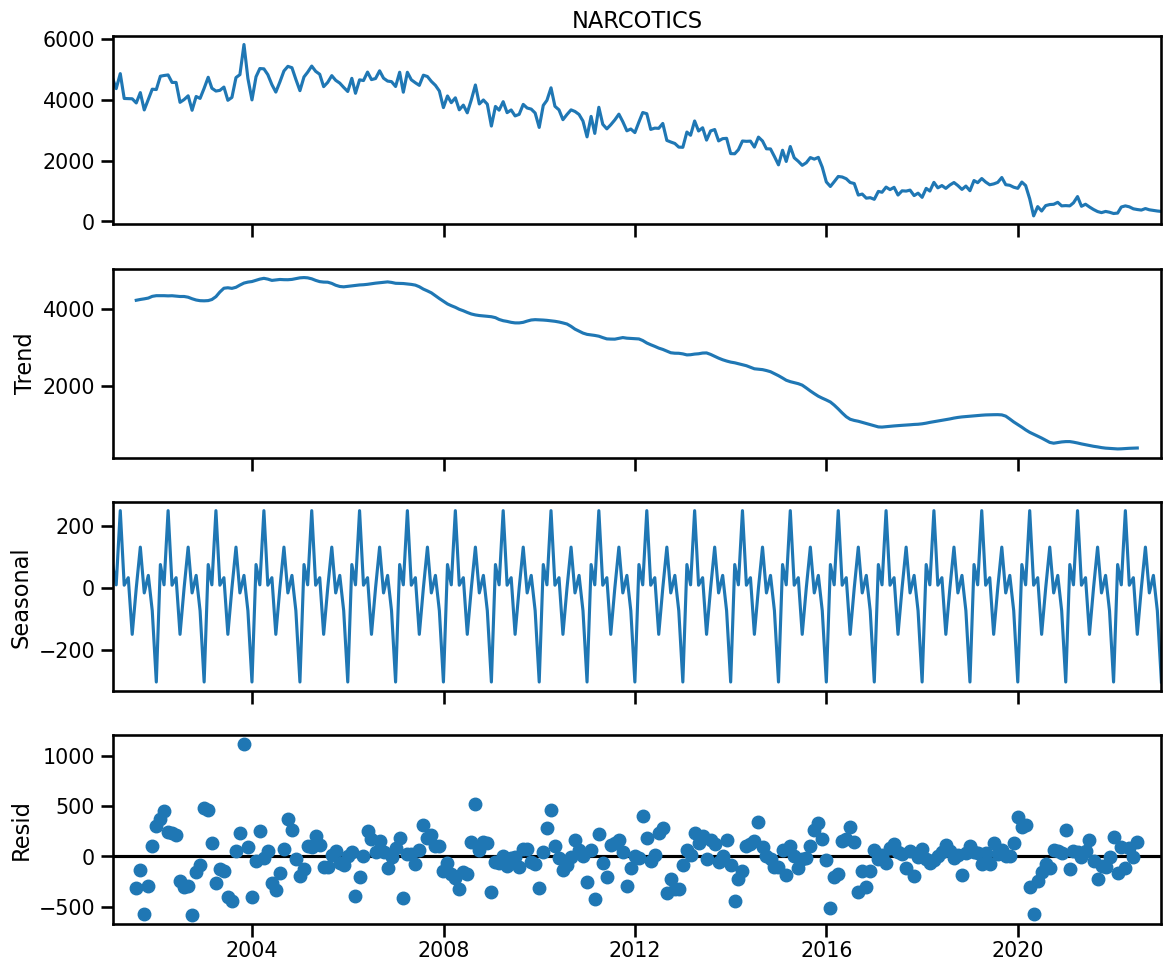

In [89]:
narc_decomp = tsa.seasonal_decompose(narc)
fig = narc_decomp.plot()
fig.set_size_inches(12,10)
fig.tight_layout()

In [94]:
nmax = narc.max()
nmin = narc.min()
seasonal_delta = decomp.seasonal.max() - decomp.seasonal.min()
tper = seasonal_delta/(nmax-nmin) * 100

print(f"The seasonal component is {seasonal_delta} which is ~{tper:.2f}% of the variation in time series.")

The seasonal component is 2549.9880952380954 which is ~45.20% of the variation in time series.


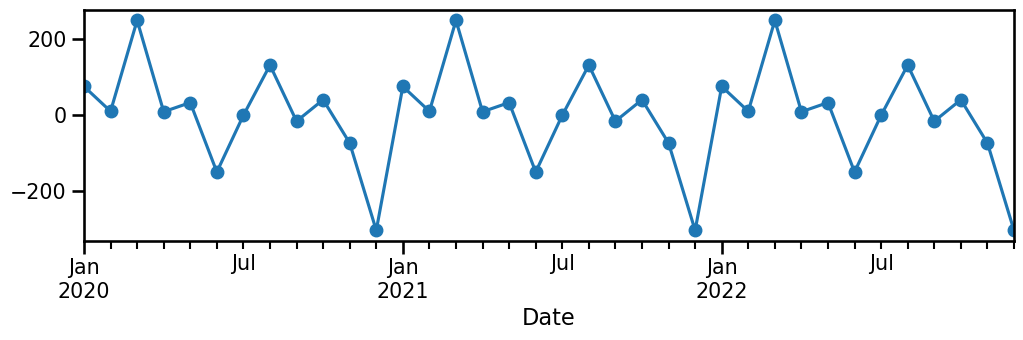

In [95]:
seasonal_narc = narc_decomp.seasonal
ax = seasonal_narc.loc['2020' : ].plot(marker = 'o')

In [96]:
# get d
d = ndiffs(narc)
d

1

In [97]:
# Determine D
D = nsdiffs(narc, m =12)
print(f'D = {D}')

D = 0


In [98]:
narc_diff = narc.diff().dropna()

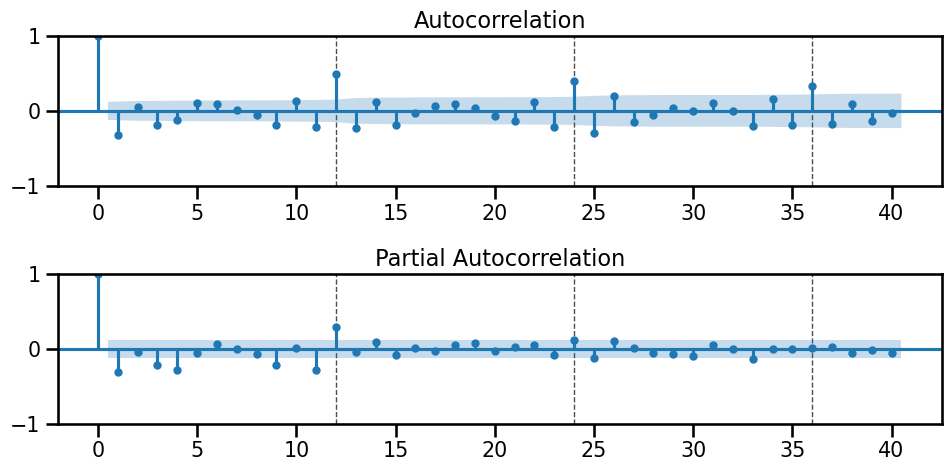

In [99]:
plot_acf_pacf(narc_diff, annotate_seas=True, m = 12);

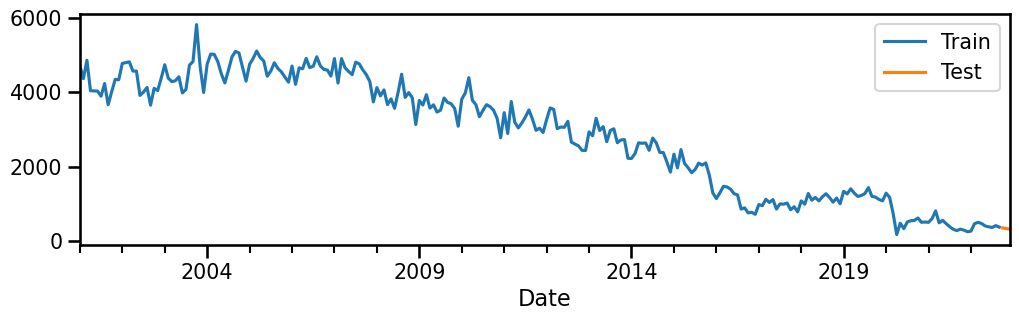

In [101]:
train_n, test_n = train_test_split(narc, test_size=.010)
ax = train_n.plot(label='Train')
test_n.plot(ax=ax, label='Test')
ax.legend();

In [102]:
# non seasonal components
p = 1
d = 1
q = 1

# seasonal components
P = 1
D = 0
Q = 1
m = 12

n_sarima = tsa.ARIMA(train_n, order = (p,d,q), seasonal_order = (P, D, Q, m)).fit()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 63.162
- MSE = 6,041.871
- RMSE = 77.729
- R^2 = -32.036
- MAPE = 19.08%


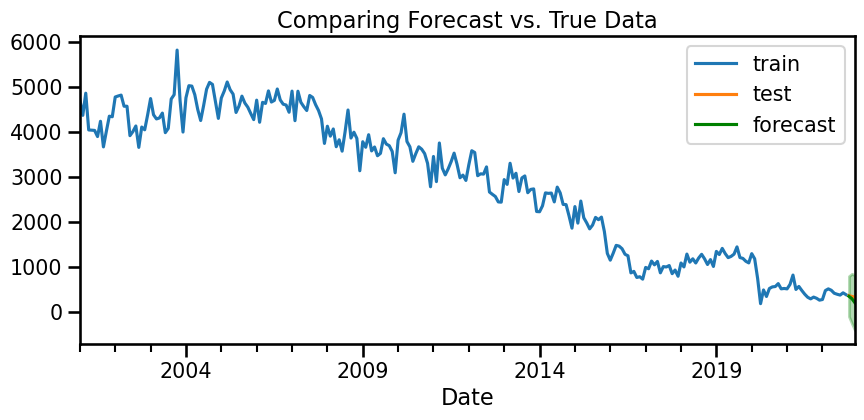

In [103]:
n_forecast_df = n_sarima.get_forecast(len(test_n)).summary_frame()
plot_forecast(train_n, test_n, n_forecast_df)
regression_metrics_ts(test_n, n_forecast_df["mean"])

In [104]:
n_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                        NARCOTICS   No. Observations:                  261
Model:             ARIMA(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -1784.536
Date:                          Fri, 08 Dec 2023   AIC                           3579.072
Time:                                  15:16:14   BIC                           3596.876
Sample:                              01-31-2001   HQIC                          3586.230
                                   - 09-30-2022                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5599      0.084      6.684      0.000       0.396       0.724
ma.L1         -0.8369      0.066    -12.738      0.000      -0.966      -0.708
ar.S.L12       0.9474      0.027     35.365      0.000       0.895       1.000
ma.S.L12      -0.7338      0.075     -9.792      0.000      -0.881      -0.587
sigma2      5.244e+04   3413.120     15.363      0.000    4.57e+04    5.91e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                47.53
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               0.35   Skew:                            -0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

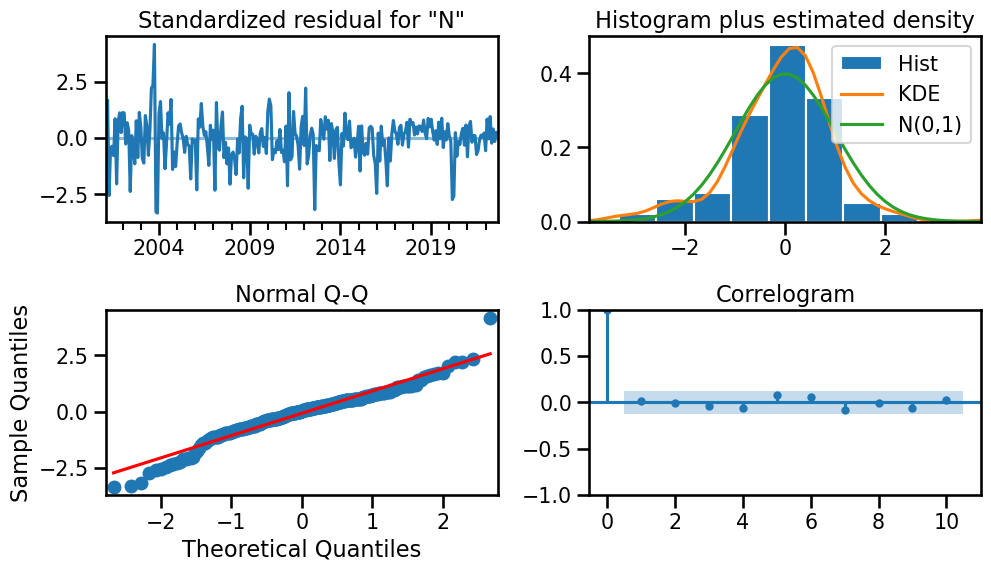

In [105]:
fig = n_sarima.plot_diagnostics()
fig.set_size_inches(10, 6)
fig.tight_layout()

In [106]:
# Define the value or range of values for p, d, q
p_values = range(0, 3)
d_values = [0]
q_values = range(0, 3)
P_values = range (0, 3)
D_values = [0]
Q_values = range (0,3)
m = [12]

# Create combinations of pdq to test
pdqPDQm_to_try = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, m))

# Display first 10 combinations
pdqPDQm_to_try[:10]

[(0, 0, 0, 0, 0, 0, 12),
 (0, 0, 0, 0, 0, 1, 12),
 (0, 0, 0, 0, 0, 2, 12),
 (0, 0, 0, 1, 0, 0, 12),
 (0, 0, 0, 1, 0, 1, 12),
 (0, 0, 0, 1, 0, 2, 12),
 (0, 0, 0, 2, 0, 0, 12),
 (0, 0, 0, 2, 0, 1, 12),
 (0, 0, 0, 2, 0, 2, 12),
 (0, 0, 1, 0, 0, 0, 12)]

In [107]:
# define starting aic as infinity
best_aic = float("inf")

# define baseline for pdq
best_pdqPDQm = (0,0,0,0,0,0,0)

# Loop through each combination
for pdqPDQm in pdqPDQm_to_try:
    order = pdqPDQm[:3] # first three values are non seasonal (p,d,q)
    seasonal_order = pdqPDQm[3:] # Remaining values for seasonal (P,D,Q,m)

    model = tsa.ARIMA(train_n, order=order, seasonal_order = seasonal_order)
    try:
        result = model.fit()
        print(pdqPDQm, result.aic)

    except:
        print(f'{pdqPDQm}: caused an error')

    # If lower, replace best AIC with new value
    if result.aic < best_aic:

        best_aic = result.aic
        best_pdqPDQm = pdqPDQm

# Print the best orders and AIC score
print("Best AIC:", best_aic)
print("Best pdqPDQm:", best_pdqPDQm)

(0, 0, 0, 0, 0, 0, 12) 4578.677387423979
(0, 0, 0, 0, 0, 1, 12) 4331.426146661808
(0, 0, 0, 0, 0, 2, 12) 4199.317417251259
(0, 0, 0, 1, 0, 0, 12) 3967.8838282619663
(0, 0, 0, 1, 0, 1, 12) 3965.437803313277
(0, 0, 0, 1, 0, 2, 12) 3965.866397002868
(0, 0, 0, 2, 0, 0, 12) 3964.5563343362046
(0, 0, 0, 2, 0, 1, 12) 3911.1461918223367
(0, 0, 0, 2, 0, 2, 12) 3886.0495635959237
(0, 0, 1, 0, 0, 0, 12) 4314.293791745816
(0, 0, 1, 0, 0, 1, 12) 4115.693278410917
(0, 0, 1, 0, 0, 2, 12) 3982.7332013954374
(0, 0, 1, 1, 0, 0, 12) 3810.2329887533497
(0, 0, 1, 1, 0, 1, 12) 3811.518670488223
(0, 0, 1, 1, 0, 2, 12) 3878.169409942053
(0, 0, 1, 2, 0, 0, 12) 3811.3007195853575
(0, 0, 1, 2, 0, 1, 12) 3830.581152565736
(0, 0, 1, 2, 0, 2, 12) 3815.355574621617
(0, 0, 2, 0, 0, 0, 12) 4126.5804961772765
(0, 0, 2, 0, 0, 1, 12) 3992.6683724674904
(0, 0, 2, 0, 0, 2, 12) 3883.339547855142
(0, 0, 2, 1, 0, 0, 12) 3791.644178773595
(0, 0, 2, 1, 0, 1, 12) 4181.785422780172
(0, 0, 2, 1, 0, 2, 12) 3996.6992289367745
(0, 0,

In [108]:
# Default auto_arima will select model based on AIC score
n_auto_model = pm.auto_arima(
    train_n,
    seasonal=True,
    m=12,
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.06 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3708.837, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3622.835, Time=0.37 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3634.966, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3707.637, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=3682.687, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=3616.040, Time=0.98 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=3598.238, Time=1.93 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=3598.150, Time=0.63 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=3642.035, Time=0.21 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=3597.788, Time=1.63 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=3628.739, Time=0.52 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.74 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=3605.203, Time=1.00 sec
 ARIMA(2,1,0)(1,0,2)[12] inte

In [109]:
# Orders for non seasonal components
p = 4 # nonseasonal AR
d = 1  # nonseasonal differencing
q = 0  # nonseasonal MA
# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period
n_sarima = tsa.ARIMA(train_n, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 33.067
- MSE = 2,496.846
- RMSE = 49.968
- R^2 = -12.652
- MAPE = 10.12%


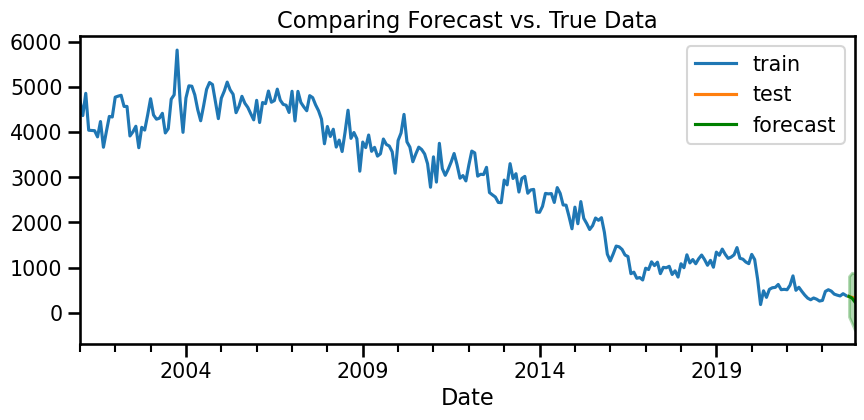

In [110]:
forecast_dfn = n_sarima.get_forecast(len(test_n)).summary_frame()
plot_forecast(train_n, test_n, forecast_dfn)
regression_metrics_ts(test_n, forecast_dfn["mean"])

### Final Model

In [111]:

len(test_n)

3

In [112]:
# Orders for non seasonal components
p = 4 # nonseasonal AR
d = 1  # nonseasonal differencing
q = 0  # nonseasonal MA
# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period
final_model_n = tsa.ARIMA(train_n, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

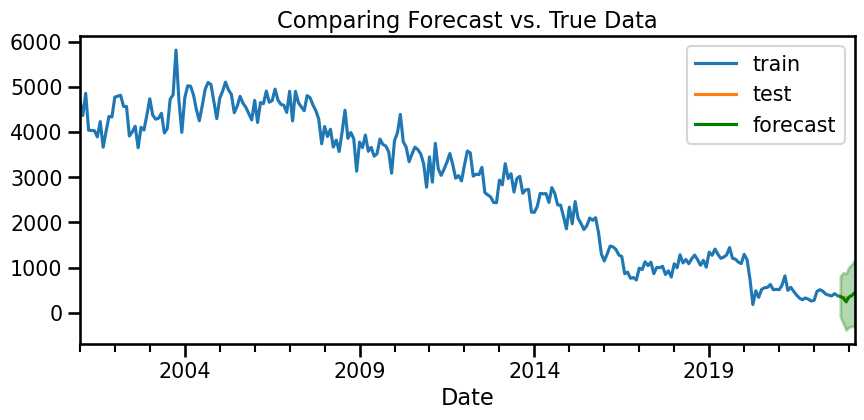

In [113]:
# future forecast
forecast_df_n  = final_model_n.get_forecast(6).summary_frame()
plot_forecast(train_n,test_n,forecast_df_n);

In [114]:
starting_value_n = forecast_df_n['mean'].iloc[0]
starting_value_n

357.99242977545134

In [115]:
final_value_n = forecast_df_n['mean'].iloc[-1]
final_value_n

443.20585926188846

In [116]:
change_n = final_value_n - starting_value_n
change_n

85.21342948643712

In [117]:
perc_change_n = (change_n / starting_value_n) * 100
perc_change_n

23.8031372730107

In [118]:
tn = ['THEFT','BATTERY']
plot_df = cc_2.loc[tn].copy()
plot_df

Primary Type  Date      
THEFT         2001-01-31    7867
              2001-02-28    6669
              2001-03-31    7766
              2001-04-30    7702
              2001-05-31    8420
                            ... 
BATTERY       2022-08-31    3740
              2022-09-30    3723
              2022-10-31    3501
              2022-11-30    3083
              2022-12-31    3009
Length: 528, dtype: int64

In [119]:
unstacked_tn = plot_df.unstack(level=0)
unstacked_tn

Primary Type  THEFT  BATTERY
Date                        
2001-01-31     7867     6527
2001-02-28     6669     6042
2001-03-31     7766     7662
2001-04-30     7702     8328
2001-05-31     8420     8887
...             ...      ...
2022-08-31     5244     3740
2022-09-30     5117     3723
2022-10-31     5242     3501
2022-11-30     4717     3083
2022-12-31     4413     3009

[264 rows x 2 columns]

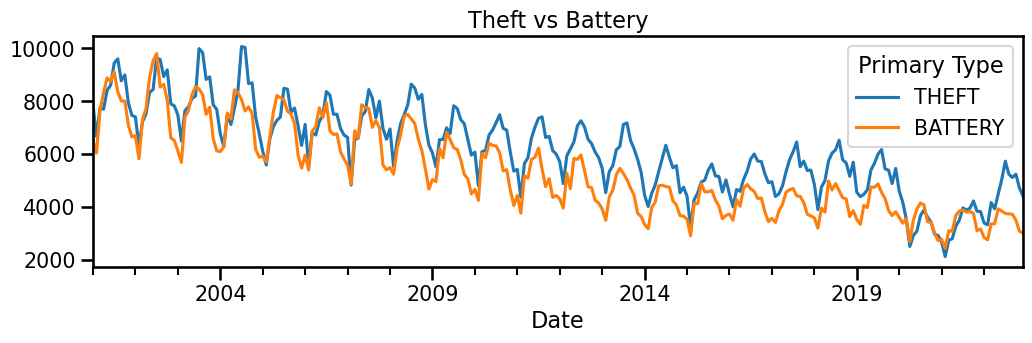

In [121]:
ax = unstacked_tn.plot(title='Theft vs Battery')

## Final Evaluation

Although both crimes are experiencing a downward trend overall. I would focus on theft prevention tactics.